## Question 1. Backpropagation

In [51]:
import numpy as np
import gzip
import idx2numpy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from operator import add
from scipy.special import expit
import math
from tqdm import tqdm
import joblib
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [2]:
training_loss = {
    "tanh" : [],
    "sigmoid": [],
    "relu": [],
    "linear": []
}

validation_loss = {
    "tanh" : [],
    "sigmoid": [],
    "relu": [],
    "linear": []
}

In [3]:
#helper function to save the learnt weights and biases.
def dump_learned_weights_and_bias(weights, bias, activation, epoch):
    weights_path = "checkpoints/"+activation+"/"+str(epoch)+"_"+activation+"_"+"weights.pkl"
    bias_path = "checkpoints/"+activation+"/"+str(epoch)+"_"+activation+"_"+"bias.pkl"
    joblib.dump(weights, weights_path)
    joblib.dump(bias, bias_path)
    return

##### **Question 1: Part 1 to Part 4**

In [4]:
class MyNeuralNetwork():
    """
    My implementation of a Neural Network Classifier.
    """

    acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
    weight_inits = ['zero', 'random', 'normal']

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
        """
        Parameters
        ----------
        n_layers : int value specifying the number of layers
        layer_sizes : integer array of size n_layers specifying the number of nodes in each layer
        activation : string specifying the activation function out of relu, sigmoid, linear, tanh
        learning_rate : float value specifying the learning rate to be used
        weight_init : string specifying the weight initialization function to be used: zero, random, normal
        batch_size : int value specifying the batch size to be used
        num_epochs : int value specifying the number of epochs to be used
        """

        if activation not in self.acti_fns:
            raise Exception('Incorrect Activation Function')

        if weight_init not in self.weight_inits:
            raise Exception('Incorrect Weight Initialization Function')
        
        l = [784] #append input and output layer to existing layers
        l.extend(layer_sizes)
        l.append(10)
        
        np.random.seed(420)
        self.n_layers = n_layers
        self.layer_sizes = l
        self.activation = activation
        self.learning_rate = learning_rate
        self.weight_init = weight_init
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.weights = {}
        self.bias = {}
        self.cache = {} #cache
        self.initialise_weights()   #initialise model weights and biases

    def compare_with_mlp(self,loss_from_your_model,X_train,y_train):
        # comparing with MLP
        # X is all data and Y is all labels
        act = self.activation
        if(act=="sigmoid"):
            act = "logistic"
        if(act=="linear"):
            act = "identity"
        mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation =act ,solver = 'sgd' , alpha = 0, batch_size = 32, max_iter=50, learning_rate_init = self.learning_rate, learning_rate = 'constant', shuffle=True, momentum = 0, nesterovs_momentum=False, validation_fraction = 0.1, verbose=True, warm_start=True)
        mlp.fit(X_train, y_train)
        mlp_file = "checkpoints/sklearn/"+"50_"+self.activation+"_model.pkl"
        joblib.dump(mlp, mlp_file)
        mlp.fit(X_train, y_train)
        mlp_file = "checkpoints/sklearn/"+"100_"+self.activation+"_model.pkl"
        joblib.dump(mlp, mlp_file)
        loss_from_sklearn = mlp.loss_curve_
        sns.set()
        plt.plot(loss_from_sklearn,label="sklearn")
        plt.plot(loss_from_your_model,label="my NN")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(loc="upper left")
        plt.savefig(self.activation+"_comparison.png")
        plt.close()

    def relu(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        x_calc = X * (X > 0)
        return x_calc

    def relu_grad(self, X):
        """
        Calculating the gradient of ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        x_calc = np.where(X < 0, 0, 1)
        return x_calc

    def sigmoid(self, X):
        """
        Calculating the Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        x_calc = expit(X)
        return x_calc

    def sigmoid_grad(self, X):
        """
        Calculating the gradient of Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        sig = self.sigmoid(X)
        x_calc = sig * (1 - sig)
        return x_calc

    def linear(self, X):
        """
        Calculating the Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        x_calc = X
        return x_calc

    def linear_grad(self, X):
        """
        Calculating the gradient of Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        x_calc = np.ones(X.shape)
        return x_calc

    def tanh(self, X):
        """
        Calculating the Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        x_calc = np.tanh(X)
        return x_calc

    def tanh_grad(self, X):
        """
        Calculating the gradient of Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        tn = self.tanh(X)
        x_calc = 1 - tn**2
        return x_calc

    def softmax(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        X_ = X - np.max(X)
        X_ = np.exp(X_)
        x_calc = X_ / np.sum(X_, axis=0)
        return x_calc

    def softmax_grad(self, X):
        """
        Calculating the gradient of Softmax activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        #calculate gradient of softmax
        z = self.softmax(X)[None, :] # (1,n)
        ex1 = np.einsum('ij,ik->ijk', z, z) # (1,n,n) [z1^2, z2*z1, z3*z1 ...]
        ex2 = np.diag(z[0]) # (n,n) [z1, 0, 0 ...]
        x_calc = ex2 - ex1 # (n,n) derivative of softmax
        return x_calc
    
    def initialise_weights(self):
        """
        Calculating the initial weights for all the layers

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        for i in range (1, len(self.layer_sizes)):
            self.bias['b'+str(i)] = self.zero_init((self.layer_sizes[i], 1)) #initialise bias with 0s
            if self.weight_init == 'zero':
                self.weights['W'+str(i)] = self.zero_init((self.layer_sizes[i], self.layer_sizes[i-1]))
                
            elif self.weight_init == 'random':
                self.weights['W'+str(i)] = self.random_init((self.layer_sizes[i], self.layer_sizes[i-1]))
                
            elif self.weight_init == 'normal':
                self.weights['W'+str(i)] = self.normal_init((self.layer_sizes[i], self.layer_sizes[i-1]))

    def return_activation_function(self, activation):
        activation_function = None
        activation_gradient = None
        if activation=="relu":
            activation_function = self.relu
            activation_gradient = self.relu_grad
        elif activation=="sigmoid":
            activation_function = self.sigmoid
            activation_gradient = self.sigmoid_grad
        elif activation=="linear":
            activation_function = self.linear
            activation_gradient = self.linear_grad
        elif activation=="tanh":
            activation_function = self.tanh
            activation_gradient = self.tanh_grad
        elif activation=="softmax":
            activation_function = self.softmax
            activation_gradient = self.softmax_grad
        else:
            print("Invalid activation function")
            return None, None
        return activation_function, activation_gradient

    def zero_init(self, shape):
        """
        Calculating the initial weights after Zero Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 2-dimensional numpy array which contains the initial weights for the requested layer
        """
        weight = np.zeros(shape)
        return weight

    def random_init(self, shape):
        """
        Calculating the initial weights after Random Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 2-dimensional numpy array which contains the initial weights for the requested layer
        """
        weight = np.random.rand(shape[0], shape[1]) * 0.01 
        return weight

    def normal_init(self, shape):
        """
        Calculating the initial weights after Normal(0,1) Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 2-dimensional numpy array which contains the initial weights for the requested layer
        """
        weight = np.random.randn(shape[0], shape[1]) * 0.01 #normal distribution with mean 0 and standard deviation 1
        return weight
    
    def one_hot_encode(self, y, n_labels):
        mat = np.eye(n_labels)[y]
        return mat

    def sg_descent(self):
        for i in range(1,self.n_layers+2):
            self.weights['W'+str(i)] -= self.gradients['dW'+str(i)] * self.learning_rate
            self.bias['b'+str(i)] -= self.gradients['db'+str(i)] * self.learning_rate
    
    def cross_entropy_loss(self, y, y_pred):
        return -np.sum(np.multiply(y.T, np.log(y_pred+1e-8)))/y.shape[0]

    def forward_propagation(self, X):
        activation, _ = self.return_activation_function(self.activation)
        self.cache['A'+str(0)] = X.T
        for i in range(1, self.n_layers+2):
            if i==1:
                self.cache['Z'+str(i)]= np.matmul(self.weights['W'+str(i)], self.cache['A'+str(0)]) + self.bias['b'+str(i)]
            else:
                self.cache['Z'+str(i)]= np.matmul(self.weights['W'+str(i)], self.cache['A'+str(i-1)]) + self.bias['b'+str(i)]
            if i==self.n_layers+1:
                self.cache['A'+str(i)] = self.softmax(self.cache['Z'+str(i)])
            else:
                self.cache['A'+str(i)] = activation(self.cache['Z'+str(i)]) 
        return self.cache['A'+str(self.n_layers+1)]

    def backward_propagation(self, y, output):
        self.gradients = {}
        _, gradient_activation = self.return_activation_function(self.activation)
        dZ = output - y.T
        for i in range(len(self.layer_sizes)-1, 0, -1):
            # print(dZ.shape, self.cache['A'+str(i-1)].shape)
            self.gradients['dW'+str(i)] = np.matmul(dZ, self.cache['A'+str(i-1)].T) * 1/y.shape[0]
            self.gradients['db'+str(i)] = np.sum(dZ, axis=1, keepdims=True) * 1/y.shape[0] 
            if i>1:
                dA = np.matmul(self.weights['W'+str(i)].T, dZ)
                dZ = dA * gradient_activation(self.cache['Z'+str(i-1)])
        return self.gradients

    def fit(self, X, y):
        """
        Fitting (training) the linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

        y : 2-dimensional numpy array one hot encoded array corresponding to the training labels.
        
        Returns
        -------
        self : an instance of self
        """
        global training_loss
        global validation_loss
        for epoch in tqdm(range(self.num_epochs)):
            print("\n----------- Epoch:", epoch+1, "of", self.num_epochs, "-----------")
            #divide dataset into training and validation
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.11, shuffle=True) #random shuffle
            n_batches = int(np.ceil(X_train.shape[0]/self.batch_size))
            for i in range(n_batches):
                # print("Training Batch:", i)
                ind1 = i*self.batch_size
                ind2 = np.min([ind1+self.batch_size, X_train.shape[0]-1])
                X_train_batch = X_train[ind1:ind2]
                y_train_batch = y_train[ind1:ind2]

                #forward propagation
                a_n = self.forward_propagation(X_train_batch)
                #back propagation and update weights
                self.backward_propagation(y_train_batch, a_n)
                self.sg_descent()
            
            if epoch==49 or epoch==99 or epoch==2:
                dump_learned_weights_and_bias(self.weights, self.bias, self.activation, epoch+1)                

            t_loss = self.cross_entropy_loss(y_train, self.predict_proba(X_train))
            v_loss = self.cross_entropy_loss(y_val, self.predict_proba(X_val))
            training_loss[self.activation].append(t_loss) 
            validation_loss[self.activation].append(v_loss)

            print("\nTraining Results for epoch:", epoch+1, "of", self.num_epochs)
            print("Training Loss:", t_loss)
            print("Training Accuracy:", self.score(X_train, np.argmax(y_train, axis=-1))*100)
            print("Validation Results for epoch:", epoch+1, "of", self.num_epochs)
            print("Validation Loss:", v_loss)
            print("Validation Accuracy:", self.score(X_val, np.argmax(y_val, axis=-1))*100)

        return self

    def predict_proba(self, X):
        """
        Predicting probabilities using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 2-dimensional numpy array of shape (n_samples, n_classes) which contains the 
            class wise prediction probabilities.
        """

        # return the numpy array y which contains the predicted values
        return self.forward_propagation(X)

    def predict(self, X):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 1-dimensional numpy array of shape (n_samples,) which contains the predicted values.
        """
        y_pred = self.forward_propagation(X)
        return np.argmax(y_pred, axis=0)

    def score(self, X, y):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as testing labels.

        Returns
        -------
        acc : float value specifying the accuracy of the model on the provided testing set
        """
        y_pred = self.forward_propagation(X)
        acc = np.mean(y == np.argmax(y_pred.T, axis=-1))
        return acc



In [5]:
def flatten(dataset):
  nimages, nfeatures = dataset.shape
  lis = np.linspace(1, nfeatures, nfeatures, dtype=np.int64)
  lis = lis.tolist()
  lis = [str(x) for x in lis]
  dataset_flat = dataset.reshape((nimages, nfeatures))
  dataset_df = pd.DataFrame(dataset_flat, columns=lis)
  return dataset_df

In [6]:
images = gzip.open('fashion-mnist_train/FashionMNIST/raw/train-images-idx3-ubyte.gz','r')
labels = gzip.open('fashion-mnist_train/FashionMNIST/raw/train-labels-idx1-ubyte.gz','r')
mnist_images = idx2numpy.convert_from_file(images)
mnist_labels = idx2numpy.convert_from_file(labels)
#split into 90:10 train:test
mnist_train, mnist_test, mnist_train_labels, mnist_test_labels = train_test_split(mnist_images, mnist_labels, test_size=0.1, random_state=42, shuffle=True)

In [7]:
scaler = StandardScaler()
scaler.fit(mnist_images.reshape(mnist_images.shape[0], -1))
# mnist_test = scaler.transform(mnist_test.reshape(mnist_test.shape[0], -1))
# mnist_train = scaler.transform(mnist_train.reshape(mnist_train.shape[0], -1))
mnist_test_flat = flatten(mnist_test.reshape(mnist_test.shape[0], -1))/255.0
mnist_train_flat = flatten(mnist_train.reshape(mnist_train.shape[0], -1))/255.0

In [8]:
all_mnist_train = mnist_images.reshape(mnist_images.shape[0], -1)/255.0

In [9]:
mnist_train_flat.head()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015686,0.003922,0.003922,0.0,0.321569,0.705882,0.305882,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0


##### **Question 1: Part 5**


In [11]:
#Training using ReLU
nn1 = MyNeuralNetwork(n_layers=3, layer_sizes=[256, 128, 64], learning_rate=0.1, num_epochs=100, batch_size=32, weight_init='normal', activation="relu")
nn1.fit(np.array(mnist_train_flat, dtype='float32'), nn1.one_hot_encode(mnist_train_labels.astype(int),10))

  0%|          | 0/100 [00:00<?, ?it/s]


----------- Epoch: 1 of 100 -----------

Training Results for epoch: 1 of 100
Training Loss: 0.8217929307877331


  1%|          | 1/100 [00:08<14:45,  8.95s/it]

Training Accuracy: 70.51810237203495
Validation Results for epoch: 1 of 100
Validation Loss: 0.8311205663313597
Validation Accuracy: 69.14141414141413

----------- Epoch: 2 of 100 -----------

Training Results for epoch: 2 of 100
Training Loss: 0.4917838474509859


  2%|▏         | 2/100 [00:16<13:33,  8.30s/it]

Training Accuracy: 81.78318768206408
Validation Results for epoch: 2 of 100
Validation Loss: 0.5003265075052694
Validation Accuracy: 81.83501683501684

----------- Epoch: 3 of 100 -----------

Training Results for epoch: 3 of 100
Training Loss: 0.41386726931175516
Training Accuracy: 85.3391593841032
Validation Results for epoch: 3 of 100
Validation Loss: 0.43065287209204645


  3%|▎         | 3/100 [00:28<15:57,  9.87s/it]

Validation Accuracy: 84.64646464646465

----------- Epoch: 4 of 100 -----------

Training Results for epoch: 4 of 100
Training Loss: 0.3643087191406052
Training Accuracy: 86.68331252600916
Validation Results for epoch: 4 of 100
Validation Loss: 0.36332360261420027


  4%|▍         | 4/100 [00:41<17:57, 11.22s/it]

Validation Accuracy: 86.63299663299662

----------- Epoch: 5 of 100 -----------

Training Results for epoch: 5 of 100
Training Loss: 0.3563039979351357
Training Accuracy: 86.61048689138576
Validation Results for epoch: 5 of 100
Validation Loss: 0.364549029896962


  5%|▌         | 5/100 [00:56<19:31, 12.33s/it]

Validation Accuracy: 86.19528619528619

----------- Epoch: 6 of 100 -----------

Training Results for epoch: 6 of 100
Training Loss: 0.31543200879383243


  6%|▌         | 6/100 [01:06<18:04, 11.54s/it]

Training Accuracy: 88.64336246358718
Validation Results for epoch: 6 of 100
Validation Loss: 0.324955698974941
Validation Accuracy: 88.56902356902356

----------- Epoch: 7 of 100 -----------

Training Results for epoch: 7 of 100
Training Loss: 0.33075675765020435


  7%|▋         | 7/100 [01:17<17:38, 11.38s/it]

Training Accuracy: 87.60299625468166
Validation Results for epoch: 7 of 100
Validation Loss: 0.35290643125730586
Validation Accuracy: 86.68350168350169

----------- Epoch: 8 of 100 -----------

Training Results for epoch: 8 of 100
Training Loss: 0.3157601437571141
Training Accuracy: 88.30420307948398
Validation Results for epoch: 8 of 100
Validation Loss: 0.3427746169075132


  8%|▊         | 8/100 [01:26<16:15, 10.61s/it]

Validation Accuracy: 87.07070707070706

----------- Epoch: 9 of 100 -----------

Training Results for epoch: 9 of 100
Training Loss: 0.2896803497832691


  9%|▉         | 9/100 [01:37<16:18, 10.75s/it]

Training Accuracy: 89.16146483562214
Validation Results for epoch: 9 of 100
Validation Loss: 0.2775896922878785
Validation Accuracy: 89.66329966329967

----------- Epoch: 10 of 100 -----------

Training Results for epoch: 10 of 100
Training Loss: 0.26865012329410004


 10%|█         | 10/100 [01:49<16:38, 11.10s/it]

Training Accuracy: 90.34124011652102
Validation Results for epoch: 10 of 100
Validation Loss: 0.2750040651959016
Validation Accuracy: 89.78114478114479

----------- Epoch: 11 of 100 -----------

Training Results for epoch: 11 of 100
Training Loss: 0.34526133888962235


 11%|█         | 11/100 [01:59<16:01, 10.80s/it]

Training Accuracy: 87.3491468997087
Validation Results for epoch: 11 of 100
Validation Loss: 0.3540264191570357
Validation Accuracy: 87.47474747474747

----------- Epoch: 12 of 100 -----------

Training Results for epoch: 12 of 100
Training Loss: 0.27281305743198403


 12%|█▏        | 12/100 [02:09<15:40, 10.69s/it]

Training Accuracy: 89.8876404494382
Validation Results for epoch: 12 of 100
Validation Loss: 0.2727044006466592
Validation Accuracy: 90.26936026936026

----------- Epoch: 13 of 100 -----------

Training Results for epoch: 13 of 100
Training Loss: 0.2463220595501448


 13%|█▎        | 13/100 [02:22<16:20, 11.26s/it]

Training Accuracy: 90.74074074074075
Validation Results for epoch: 13 of 100
Validation Loss: 0.2701770475518959
Validation Accuracy: 90.23569023569024

----------- Epoch: 14 of 100 -----------

Training Results for epoch: 14 of 100
Training Loss: 0.27530617766654975


 14%|█▍        | 14/100 [02:29<14:22, 10.03s/it]

Training Accuracy: 89.42363712026633
Validation Results for epoch: 14 of 100
Validation Loss: 0.2970876809792951
Validation Accuracy: 88.53535353535354

----------- Epoch: 15 of 100 -----------

Training Results for epoch: 15 of 100
Training Loss: 0.24908844557425674


 15%|█▌        | 15/100 [02:37<13:22,  9.44s/it]

Training Accuracy: 90.7136912193092
Validation Results for epoch: 15 of 100
Validation Loss: 0.2666384430243388
Validation Accuracy: 90.11784511784512

----------- Epoch: 16 of 100 -----------

Training Results for epoch: 16 of 100
Training Loss: 0.2744197896209238


 16%|█▌        | 16/100 [02:44<12:15,  8.75s/it]

Training Accuracy: 89.31751976695796
Validation Results for epoch: 16 of 100
Validation Loss: 0.282592884250055
Validation Accuracy: 89.52861952861953

----------- Epoch: 17 of 100 -----------

Training Results for epoch: 17 of 100
Training Loss: 0.2089604694633078


 17%|█▋        | 17/100 [02:52<11:47,  8.53s/it]

Training Accuracy: 92.18476903870162
Validation Results for epoch: 17 of 100
Validation Loss: 0.22738180526194327
Validation Accuracy: 91.46464646464646

----------- Epoch: 18 of 100 -----------

Training Results for epoch: 18 of 100
Training Loss: 0.20978661164212942


 18%|█▊        | 18/100 [02:59<11:02,  8.08s/it]

Training Accuracy: 92.18476903870162
Validation Results for epoch: 18 of 100
Validation Loss: 0.22263336927629435
Validation Accuracy: 91.11111111111111

----------- Epoch: 19 of 100 -----------

Training Results for epoch: 19 of 100
Training Loss: 0.21578801430607855


 19%|█▉        | 19/100 [03:07<10:50,  8.03s/it]

Training Accuracy: 91.78318768206408
Validation Results for epoch: 19 of 100
Validation Loss: 0.22960073871545617
Validation Accuracy: 91.0942760942761

----------- Epoch: 20 of 100 -----------

Training Results for epoch: 20 of 100
Training Loss: 0.20199770166010939


 20%|██        | 20/100 [03:14<10:20,  7.75s/it]

Training Accuracy: 92.24719101123596
Validation Results for epoch: 20 of 100
Validation Loss: 0.2120160222751752
Validation Accuracy: 91.95286195286195

----------- Epoch: 21 of 100 -----------

Training Results for epoch: 21 of 100
Training Loss: 0.19512774538371422


 21%|██        | 21/100 [03:22<10:16,  7.80s/it]

Training Accuracy: 92.62172284644194
Validation Results for epoch: 21 of 100
Validation Loss: 0.2125546844339821
Validation Accuracy: 92.05387205387206

----------- Epoch: 22 of 100 -----------

Training Results for epoch: 22 of 100
Training Loss: 0.18617579096600015


 22%|██▏       | 22/100 [03:29<09:50,  7.57s/it]

Training Accuracy: 92.87973366625052
Validation Results for epoch: 22 of 100
Validation Loss: 0.1914124938470754
Validation Accuracy: 92.52525252525253

----------- Epoch: 23 of 100 -----------

Training Results for epoch: 23 of 100
Training Loss: 0.20762764700820685


 23%|██▎       | 23/100 [03:37<09:51,  7.68s/it]

Training Accuracy: 91.93091968372867
Validation Results for epoch: 23 of 100
Validation Loss: 0.2152219196258846
Validation Accuracy: 91.95286195286195

----------- Epoch: 24 of 100 -----------

Training Results for epoch: 24 of 100
Training Loss: 0.2765747713346997


 24%|██▍       | 24/100 [03:44<09:28,  7.49s/it]

Training Accuracy: 89.45692883895131
Validation Results for epoch: 24 of 100
Validation Loss: 0.29893671566882996
Validation Accuracy: 88.65319865319864

----------- Epoch: 25 of 100 -----------

Training Results for epoch: 25 of 100
Training Loss: 0.18290118661750382


 25%|██▌       | 25/100 [03:52<09:32,  7.63s/it]

Training Accuracy: 92.99417394923013
Validation Results for epoch: 25 of 100
Validation Loss: 0.18015477625514628
Validation Accuracy: 93.04713804713805

----------- Epoch: 26 of 100 -----------

Training Results for epoch: 26 of 100
Training Loss: 0.1721139482465362


 26%|██▌       | 26/100 [03:59<09:13,  7.48s/it]

Training Accuracy: 93.27923429047024
Validation Results for epoch: 26 of 100
Validation Loss: 0.19879322280463393
Validation Accuracy: 92.3063973063973

----------- Epoch: 27 of 100 -----------

Training Results for epoch: 27 of 100
Training Loss: 0.17164311392414322


 27%|██▋       | 27/100 [04:07<09:15,  7.60s/it]

Training Accuracy: 93.4560965459842
Validation Results for epoch: 27 of 100
Validation Loss: 0.19083964666542425
Validation Accuracy: 92.45791245791246

----------- Epoch: 28 of 100 -----------

Training Results for epoch: 28 of 100
Training Loss: 0.16766596899517286


 28%|██▊       | 28/100 [04:14<08:54,  7.43s/it]

Training Accuracy: 93.42072409488141
Validation Results for epoch: 28 of 100
Validation Loss: 0.18392987451880907
Validation Accuracy: 92.92929292929293

----------- Epoch: 29 of 100 -----------

Training Results for epoch: 29 of 100
Training Loss: 0.1698344114976906


 29%|██▉       | 29/100 [04:22<08:59,  7.60s/it]

Training Accuracy: 93.50395339159384
Validation Results for epoch: 29 of 100
Validation Loss: 0.17588825086959087
Validation Accuracy: 93.26599326599326

----------- Epoch: 30 of 100 -----------

Training Results for epoch: 30 of 100
Training Loss: 0.14970232066096784


 30%|███       | 30/100 [04:29<08:39,  7.43s/it]

Training Accuracy: 94.2675821889305
Validation Results for epoch: 30 of 100
Validation Loss: 0.159830753391289
Validation Accuracy: 94.15824915824916

----------- Epoch: 31 of 100 -----------

Training Results for epoch: 31 of 100
Training Loss: 0.1598244809935349


 31%|███       | 31/100 [04:38<09:03,  7.88s/it]

Training Accuracy: 93.84727424053267
Validation Results for epoch: 31 of 100
Validation Loss: 0.18276640287571785
Validation Accuracy: 93.08080808080808

----------- Epoch: 32 of 100 -----------

Training Results for epoch: 32 of 100
Training Loss: 0.16228441619073009


 32%|███▏      | 32/100 [04:45<08:43,  7.71s/it]

Training Accuracy: 93.70162297128589
Validation Results for epoch: 32 of 100
Validation Loss: 0.17351581479939382
Validation Accuracy: 93.35016835016835

----------- Epoch: 33 of 100 -----------

Training Results for epoch: 33 of 100
Training Loss: 0.16583059938954925


 33%|███▎      | 33/100 [04:54<08:45,  7.84s/it]

Training Accuracy: 93.45401581356637
Validation Results for epoch: 33 of 100
Validation Loss: 0.16540538515708994
Validation Accuracy: 93.7037037037037

----------- Epoch: 34 of 100 -----------

Training Results for epoch: 34 of 100
Training Loss: 0.15226562569352817


 34%|███▍      | 34/100 [05:01<08:24,  7.65s/it]

Training Accuracy: 94.28838951310861
Validation Results for epoch: 34 of 100
Validation Loss: 0.1751393741986045
Validation Accuracy: 93.23232323232324

----------- Epoch: 35 of 100 -----------

Training Results for epoch: 35 of 100
Training Loss: 0.15978909903588517


 35%|███▌      | 35/100 [05:11<09:06,  8.41s/it]

Training Accuracy: 94.01373283395755
Validation Results for epoch: 35 of 100
Validation Loss: 0.16059463146097364
Validation Accuracy: 93.77104377104376

----------- Epoch: 36 of 100 -----------

Training Results for epoch: 36 of 100
Training Loss: 0.13978873107925976


 36%|███▌      | 36/100 [05:18<08:41,  8.14s/it]

Training Accuracy: 94.68164794007491
Validation Results for epoch: 36 of 100
Validation Loss: 0.16375651440107566
Validation Accuracy: 94.04040404040404

----------- Epoch: 37 of 100 -----------

Training Results for epoch: 37 of 100
Training Loss: 0.13332153636480215


 37%|███▋      | 37/100 [06:38<30:54, 29.44s/it]

Training Accuracy: 94.98959633791094
Validation Results for epoch: 37 of 100
Validation Loss: 0.15753795788864514
Validation Accuracy: 94.17508417508418

----------- Epoch: 38 of 100 -----------

Training Results for epoch: 38 of 100
Training Loss: 0.1543596223791092


 38%|███▊      | 38/100 [06:46<23:58, 23.20s/it]

Training Accuracy: 94.15938410320433
Validation Results for epoch: 38 of 100
Validation Loss: 0.1757682129932712
Validation Accuracy: 93.46801346801347

----------- Epoch: 39 of 100 -----------

Training Results for epoch: 39 of 100
Training Loss: 0.13428971031710552


 39%|███▉      | 39/100 [06:54<18:59, 18.68s/it]

Training Accuracy: 95.03537245110279
Validation Results for epoch: 39 of 100
Validation Loss: 0.15783239970036914
Validation Accuracy: 94.15824915824916

----------- Epoch: 40 of 100 -----------

Training Results for epoch: 40 of 100
Training Loss: 0.12543681462076778


 40%|████      | 40/100 [07:02<15:14, 15.23s/it]

Training Accuracy: 95.44111527257596
Validation Results for epoch: 40 of 100
Validation Loss: 0.13266620187149988
Validation Accuracy: 94.98316498316498

----------- Epoch: 41 of 100 -----------

Training Results for epoch: 41 of 100
Training Loss: 0.14334818929539345


 41%|████      | 41/100 [07:09<12:46, 13.00s/it]

Training Accuracy: 94.55472326258844
Validation Results for epoch: 41 of 100
Validation Loss: 0.1553727565337648
Validation Accuracy: 93.82154882154882

----------- Epoch: 42 of 100 -----------

Training Results for epoch: 42 of 100
Training Loss: 0.1327172806131987


 42%|████▏     | 42/100 [07:16<10:47, 11.16s/it]

Training Accuracy: 94.83978360382854
Validation Results for epoch: 42 of 100
Validation Loss: 0.1379697262853445
Validation Accuracy: 94.4949494949495

----------- Epoch: 43 of 100 -----------

Training Results for epoch: 43 of 100
Training Loss: 0.12806563834033866


 43%|████▎     | 43/100 [07:24<09:40, 10.18s/it]

Training Accuracy: 94.90844777361632
Validation Results for epoch: 43 of 100
Validation Loss: 0.14231835371318374
Validation Accuracy: 94.39393939393939

----------- Epoch: 44 of 100 -----------

Training Results for epoch: 44 of 100
Training Loss: 0.12535605952774062


 44%|████▍     | 44/100 [07:31<08:36,  9.23s/it]

Training Accuracy: 95.15813566375364
Validation Results for epoch: 44 of 100
Validation Loss: 0.13320018097836572
Validation Accuracy: 94.8989898989899

----------- Epoch: 45 of 100 -----------

Training Results for epoch: 45 of 100
Training Loss: 0.13334811675561675


 45%|████▌     | 45/100 [07:39<08:06,  8.85s/it]

Training Accuracy: 94.87931751976696
Validation Results for epoch: 45 of 100
Validation Loss: 0.14705669367293062
Validation Accuracy: 94.37710437710439

----------- Epoch: 46 of 100 -----------

Training Results for epoch: 46 of 100
Training Loss: 0.12366595556550461


 46%|████▌     | 46/100 [07:46<07:30,  8.33s/it]

Training Accuracy: 95.1706200582605
Validation Results for epoch: 46 of 100
Validation Loss: 0.137108007386809
Validation Accuracy: 94.51178451178451

----------- Epoch: 47 of 100 -----------

Training Results for epoch: 47 of 100
Training Loss: 0.1171318129628042


 47%|████▋     | 47/100 [07:54<07:17,  8.25s/it]

Training Accuracy: 95.52434456928839
Validation Results for epoch: 47 of 100
Validation Loss: 0.129433806256003
Validation Accuracy: 94.8989898989899

----------- Epoch: 48 of 100 -----------

Training Results for epoch: 48 of 100
Training Loss: 0.11384049370190064


 48%|████▊     | 48/100 [08:01<06:48,  7.86s/it]

Training Accuracy: 95.63046192259675
Validation Results for epoch: 48 of 100
Validation Loss: 0.11534284695479502
Validation Accuracy: 95.8080808080808

----------- Epoch: 49 of 100 -----------

Training Results for epoch: 49 of 100
Training Loss: 0.11293828022284416


 49%|████▉     | 49/100 [08:09<06:42,  7.89s/it]

Training Accuracy: 95.61173533083645
Validation Results for epoch: 49 of 100
Validation Loss: 0.12842139608375086
Validation Accuracy: 95.53872053872054

----------- Epoch: 50 of 100 -----------

Training Results for epoch: 50 of 100
Training Loss: 0.10664533081301318


 50%|█████     | 50/100 [08:16<06:21,  7.63s/it]

Training Accuracy: 95.92800665834373
Validation Results for epoch: 50 of 100
Validation Loss: 0.10258230858072957
Validation Accuracy: 96.32996632996634

----------- Epoch: 51 of 100 -----------

Training Results for epoch: 51 of 100
Training Loss: 0.13097900411522126


 51%|█████     | 51/100 [08:23<06:05,  7.47s/it]

Training Accuracy: 94.81897627965043
Validation Results for epoch: 51 of 100
Validation Loss: 0.1477901805799011
Validation Accuracy: 93.63636363636364

----------- Epoch: 52 of 100 -----------

Training Results for epoch: 52 of 100
Training Loss: 0.1150429531917523


 52%|█████▏    | 52/100 [08:32<06:12,  7.76s/it]

Training Accuracy: 95.56387848522681
Validation Results for epoch: 52 of 100
Validation Loss: 0.12358410260178196
Validation Accuracy: 95.01683501683502

----------- Epoch: 53 of 100 -----------

Training Results for epoch: 53 of 100
Training Loss: 0.11357291355860064


 53%|█████▎    | 53/100 [08:39<05:56,  7.57s/it]

Training Accuracy: 95.68456096545984
Validation Results for epoch: 53 of 100
Validation Loss: 0.13230487058075316
Validation Accuracy: 94.81481481481482

----------- Epoch: 54 of 100 -----------

Training Results for epoch: 54 of 100
Training Loss: 0.09666719938714165


 54%|█████▍    | 54/100 [08:47<05:56,  7.75s/it]

Training Accuracy: 96.27965043695382
Validation Results for epoch: 54 of 100
Validation Loss: 0.11709302120361716
Validation Accuracy: 95.85858585858585

----------- Epoch: 55 of 100 -----------

Training Results for epoch: 55 of 100
Training Loss: 0.09284077024509105


 55%|█████▌    | 55/100 [08:54<05:41,  7.58s/it]

Training Accuracy: 96.41905950894714
Validation Results for epoch: 55 of 100
Validation Loss: 0.10311239008387914
Validation Accuracy: 96.07744107744108

----------- Epoch: 56 of 100 -----------

Training Results for epoch: 56 of 100
Training Loss: 0.10069988232286808


 56%|█████▌    | 56/100 [09:03<05:50,  7.96s/it]

Training Accuracy: 96.28173116937162
Validation Results for epoch: 56 of 100
Validation Loss: 0.11603133284961188
Validation Accuracy: 95.62289562289563

----------- Epoch: 57 of 100 -----------

Training Results for epoch: 57 of 100
Training Loss: 0.09157013974694711
Training Accuracy: 96.47315855181023
Validation Results for epoch: 57 of 100
Validation Loss: 0.11256154573484482


 57%|█████▋    | 57/100 [09:13<06:09,  8.58s/it]

Validation Accuracy: 96.11111111111111

----------- Epoch: 58 of 100 -----------

Training Results for epoch: 58 of 100
Training Loss: 0.11924388489656453
Training Accuracy: 95.27465667915106
Validation Results for epoch: 58 of 100
Validation Loss: 0.12438655832448126


 58%|█████▊    | 58/100 [09:29<07:30, 10.72s/it]

Validation Accuracy: 94.84848484848484

----------- Epoch: 59 of 100 -----------

Training Results for epoch: 59 of 100
Training Loss: 0.09433680134915824
Training Accuracy: 96.32334581772784
Validation Results for epoch: 59 of 100
Validation Loss: 0.11127643138576004


 59%|█████▉    | 59/100 [09:39<07:19, 10.71s/it]

Validation Accuracy: 95.6902356902357

----------- Epoch: 60 of 100 -----------

Training Results for epoch: 60 of 100
Training Loss: 0.0922187693559986


 60%|██████    | 60/100 [09:53<07:36, 11.42s/it]

Training Accuracy: 96.47940074906367
Validation Results for epoch: 60 of 100
Validation Loss: 0.0907166997487917
Validation Accuracy: 96.68350168350169

----------- Epoch: 61 of 100 -----------

Training Results for epoch: 61 of 100
Training Loss: 0.09863005496338642


 61%|██████    | 61/100 [10:00<06:37, 10.19s/it]

Training Accuracy: 96.2401165210154
Validation Results for epoch: 61 of 100
Validation Loss: 0.10606421822400418
Validation Accuracy: 96.06060606060606

----------- Epoch: 62 of 100 -----------

Training Results for epoch: 62 of 100
Training Loss: 0.10851470710836207


 62%|██████▏   | 62/100 [10:14<07:15, 11.47s/it]

Training Accuracy: 95.78027465667915
Validation Results for epoch: 62 of 100
Validation Loss: 0.11355057852891914
Validation Accuracy: 95.63973063973063

----------- Epoch: 63 of 100 -----------

Training Results for epoch: 63 of 100
Training Loss: 0.0814178485488647


 63%|██████▎   | 63/100 [10:24<06:47, 11.01s/it]

Training Accuracy: 96.87473990844776
Validation Results for epoch: 63 of 100
Validation Loss: 0.0807810023127118
Validation Accuracy: 96.96969696969697

----------- Epoch: 64 of 100 -----------

Training Results for epoch: 64 of 100
Training Loss: 0.08418194011915678


 64%|██████▍   | 64/100 [10:37<06:57, 11.61s/it]

Training Accuracy: 96.77694548481065
Validation Results for epoch: 64 of 100
Validation Loss: 0.10303448967189081
Validation Accuracy: 96.06060606060606

----------- Epoch: 65 of 100 -----------

Training Results for epoch: 65 of 100
Training Loss: 0.07909686823063886


 65%|██████▌   | 65/100 [10:45<06:02, 10.37s/it]

Training Accuracy: 96.96004993757803
Validation Results for epoch: 65 of 100
Validation Loss: 0.09674419628772987
Validation Accuracy: 96.06060606060606

----------- Epoch: 66 of 100 -----------

Training Results for epoch: 66 of 100
Training Loss: 0.08354734645971575


 66%|██████▌   | 66/100 [10:57<06:10, 10.89s/it]

Training Accuracy: 96.79151061173533
Validation Results for epoch: 66 of 100
Validation Loss: 0.09516787393161003
Validation Accuracy: 96.32996632996634

----------- Epoch: 67 of 100 -----------

Training Results for epoch: 67 of 100
Training Loss: 0.08088787865351187


 67%|██████▋   | 67/100 [11:09<06:08, 11.15s/it]

Training Accuracy: 97.02039117769455
Validation Results for epoch: 67 of 100
Validation Loss: 0.08438839093697313
Validation Accuracy: 96.73400673400674

----------- Epoch: 68 of 100 -----------

Training Results for epoch: 68 of 100
Training Loss: 0.07838021223852898


 68%|██████▊   | 68/100 [11:21<06:05, 11.44s/it]

Training Accuracy: 96.92259675405744
Validation Results for epoch: 68 of 100
Validation Loss: 0.09507217842431855
Validation Accuracy: 96.1952861952862

----------- Epoch: 69 of 100 -----------

Training Results for epoch: 69 of 100
Training Loss: 0.0799713385026805
Training Accuracy: 96.88098210570121
Validation Results for epoch: 69 of 100
Validation Loss: 0.08804406814094583


 69%|██████▉   | 69/100 [11:31<05:43, 11.07s/it]

Validation Accuracy: 96.63299663299664

----------- Epoch: 70 of 100 -----------

Training Results for epoch: 70 of 100
Training Loss: 0.0659901484877964


 70%|███████   | 70/100 [11:44<05:53, 11.79s/it]

Training Accuracy: 97.46982937994174
Validation Results for epoch: 70 of 100
Validation Loss: 0.07018898494260059
Validation Accuracy: 97.35690235690235

----------- Epoch: 71 of 100 -----------

Training Results for epoch: 71 of 100
Training Loss: 0.0736964223476171


 71%|███████   | 71/100 [11:52<05:08, 10.65s/it]

Training Accuracy: 97.20349563046192
Validation Results for epoch: 71 of 100
Validation Loss: 0.0875776679076288
Validation Accuracy: 96.70033670033669

----------- Epoch: 72 of 100 -----------

Training Results for epoch: 72 of 100
Training Loss: 0.07620873211176048


 72%|███████▏  | 72/100 [12:02<04:45, 10.21s/it]

Training Accuracy: 97.06200582605076
Validation Results for epoch: 72 of 100
Validation Loss: 0.08693953475532878
Validation Accuracy: 96.98653198653199

----------- Epoch: 73 of 100 -----------

Training Results for epoch: 73 of 100
Training Loss: 0.07117711456148378


 73%|███████▎  | 73/100 [12:13<04:46, 10.62s/it]

Training Accuracy: 97.29920932168123
Validation Results for epoch: 73 of 100
Validation Loss: 0.07674209788017204
Validation Accuracy: 97.07070707070707

----------- Epoch: 74 of 100 -----------

Training Results for epoch: 74 of 100
Training Loss: 0.07813385344477815


 74%|███████▍  | 74/100 [12:24<04:36, 10.62s/it]

Training Accuracy: 96.96213066999584
Validation Results for epoch: 74 of 100
Validation Loss: 0.09252675913183278
Validation Accuracy: 96.36363636363636

----------- Epoch: 75 of 100 -----------

Training Results for epoch: 75 of 100
Training Loss: 0.08793918506655213


 75%|███████▌  | 75/100 [12:32<04:06,  9.86s/it]

Training Accuracy: 96.60840615896795
Validation Results for epoch: 75 of 100
Validation Loss: 0.09556707451772217
Validation Accuracy: 96.46464646464646

----------- Epoch: 76 of 100 -----------

Training Results for epoch: 76 of 100
Training Loss: 0.07258406717697145


 76%|███████▌  | 76/100 [12:40<03:44,  9.34s/it]

Training Accuracy: 97.19933416562631
Validation Results for epoch: 76 of 100
Validation Loss: 0.07086918689796559
Validation Accuracy: 97.20538720538721

----------- Epoch: 77 of 100 -----------

Training Results for epoch: 77 of 100
Training Loss: 0.07175233399241877


 77%|███████▋  | 77/100 [12:48<03:24,  8.88s/it]

Training Accuracy: 97.27632126508531
Validation Results for epoch: 77 of 100
Validation Loss: 0.07657818938144154
Validation Accuracy: 96.9023569023569

----------- Epoch: 78 of 100 -----------

Training Results for epoch: 78 of 100
Training Loss: 0.06754202825267354


 78%|███████▊  | 78/100 [12:58<03:24,  9.28s/it]

Training Accuracy: 97.38451935081149
Validation Results for epoch: 78 of 100
Validation Loss: 0.07925854260943878
Validation Accuracy: 96.8013468013468

----------- Epoch: 79 of 100 -----------

Training Results for epoch: 79 of 100
Training Loss: 0.0743819856248538


 79%|███████▉  | 79/100 [13:07<03:12,  9.16s/it]

Training Accuracy: 97.22638368705785
Validation Results for epoch: 79 of 100
Validation Loss: 0.08374504037379743
Validation Accuracy: 96.70033670033669

----------- Epoch: 80 of 100 -----------

Training Results for epoch: 80 of 100
Training Loss: 0.07008331399185853


 80%|████████  | 80/100 [13:19<03:24, 10.20s/it]

Training Accuracy: 97.31585518102372
Validation Results for epoch: 80 of 100
Validation Loss: 0.08519834184324734
Validation Accuracy: 96.66666666666667

----------- Epoch: 81 of 100 -----------

Training Results for epoch: 81 of 100
Training Loss: 0.0519515446758139


 81%|████████  | 81/100 [13:28<03:04,  9.72s/it]

Training Accuracy: 98.02330420307949
Validation Results for epoch: 81 of 100
Validation Loss: 0.055453800311342547
Validation Accuracy: 97.65993265993266

----------- Epoch: 82 of 100 -----------

Training Results for epoch: 82 of 100
Training Loss: 0.0918434641556099


 82%|████████▏ | 82/100 [13:38<02:56,  9.80s/it]

Training Accuracy: 96.4294631710362
Validation Results for epoch: 82 of 100
Validation Loss: 0.10595113062259012
Validation Accuracy: 96.01010101010101

----------- Epoch: 83 of 100 -----------

Training Results for epoch: 83 of 100
Training Loss: 0.05711655418452724
Training Accuracy: 97.80482729920932
Validation Results for epoch: 83 of 100
Validation Loss: 0.0650043781036304


 83%|████████▎ | 83/100 [13:47<02:39,  9.41s/it]

Validation Accuracy: 97.45791245791246

----------- Epoch: 84 of 100 -----------

Training Results for epoch: 84 of 100
Training Loss: 0.062822097841889


 84%|████████▍ | 84/100 [13:57<02:35,  9.73s/it]

Training Accuracy: 97.51352476071577
Validation Results for epoch: 84 of 100
Validation Loss: 0.07631895149110192
Validation Accuracy: 96.96969696969697

----------- Epoch: 85 of 100 -----------

Training Results for epoch: 85 of 100
Training Loss: 0.0652502514077011


 85%|████████▌ | 85/100 [14:05<02:15,  9.06s/it]

Training Accuracy: 97.52184769038702
Validation Results for epoch: 85 of 100
Validation Loss: 0.07862625893163981
Validation Accuracy: 96.88552188552188

----------- Epoch: 86 of 100 -----------

Training Results for epoch: 86 of 100
Training Loss: 0.08027575668390806


 86%|████████▌ | 86/100 [14:14<02:08,  9.16s/it]

Training Accuracy: 96.86849771119435
Validation Results for epoch: 86 of 100
Validation Loss: 0.08848002847134079
Validation Accuracy: 96.44781144781145

----------- Epoch: 87 of 100 -----------

Training Results for epoch: 87 of 100
Training Loss: 0.05591660606551534


 87%|████████▋ | 87/100 [14:22<01:53,  8.72s/it]

Training Accuracy: 97.86516853932584
Validation Results for epoch: 87 of 100
Validation Loss: 0.07215434089809937
Validation Accuracy: 97.17171717171718

----------- Epoch: 88 of 100 -----------

Training Results for epoch: 88 of 100
Training Loss: 0.05805447467673457
Training Accuracy: 97.74864752392843
Validation Results for epoch: 88 of 100
Validation Loss: 0.06838577116946992


 88%|████████▊ | 88/100 [14:32<01:52,  9.34s/it]

Validation Accuracy: 97.45791245791246

----------- Epoch: 89 of 100 -----------

Training Results for epoch: 89 of 100
Training Loss: 0.06325408387743087


 89%|████████▉ | 89/100 [14:42<01:44,  9.49s/it]

Training Accuracy: 97.57386600083228
Validation Results for epoch: 89 of 100
Validation Loss: 0.07556686046484377
Validation Accuracy: 97.13804713804713

----------- Epoch: 90 of 100 -----------

Training Results for epoch: 90 of 100
Training Loss: 0.05839644946545182


 90%|█████████ | 90/100 [14:56<01:46, 10.64s/it]

Training Accuracy: 97.75488972118185
Validation Results for epoch: 90 of 100
Validation Loss: 0.060821548323140046
Validation Accuracy: 97.57575757575758

----------- Epoch: 91 of 100 -----------

Training Results for epoch: 91 of 100
Training Loss: 0.057228435412052595


 91%|█████████ | 91/100 [15:05<01:31, 10.15s/it]

Training Accuracy: 97.77777777777777
Validation Results for epoch: 91 of 100
Validation Loss: 0.06143853653695534
Validation Accuracy: 97.52525252525253

----------- Epoch: 92 of 100 -----------

Training Results for epoch: 92 of 100
Training Loss: 0.04886218600287988


 92%|█████████▏| 92/100 [15:14<01:20, 10.02s/it]

Training Accuracy: 98.12942155638785
Validation Results for epoch: 92 of 100
Validation Loss: 0.05266271436609578
Validation Accuracy: 98.06397306397307

----------- Epoch: 93 of 100 -----------

Training Results for epoch: 93 of 100
Training Loss: 0.06335443764862297


 93%|█████████▎| 93/100 [15:22<01:05,  9.29s/it]

Training Accuracy: 97.5010403662089
Validation Results for epoch: 93 of 100
Validation Loss: 0.07056456735478227
Validation Accuracy: 97.49158249158249

----------- Epoch: 94 of 100 -----------

Training Results for epoch: 94 of 100
Training Loss: 0.04855270110585847


 94%|█████████▍| 94/100 [15:32<00:56,  9.48s/it]

Training Accuracy: 98.11277569704536
Validation Results for epoch: 94 of 100
Validation Loss: 0.061060854364803505
Validation Accuracy: 97.57575757575758

----------- Epoch: 95 of 100 -----------

Training Results for epoch: 95 of 100
Training Loss: 0.0728943650407488


 95%|█████████▌| 95/100 [15:40<00:45,  9.11s/it]

Training Accuracy: 97.15355805243445
Validation Results for epoch: 95 of 100
Validation Loss: 0.07406892062137292
Validation Accuracy: 97.12121212121212

----------- Epoch: 96 of 100 -----------

Training Results for epoch: 96 of 100
Training Loss: 0.0583440870154988


 96%|█████████▌| 96/100 [15:49<00:36,  9.12s/it]

Training Accuracy: 97.72159800249688
Validation Results for epoch: 96 of 100
Validation Loss: 0.06265056365834536
Validation Accuracy: 97.39057239057239

----------- Epoch: 97 of 100 -----------

Training Results for epoch: 97 of 100
Training Loss: 0.04352565980308201


 97%|█████████▋| 97/100 [15:58<00:26,  8.98s/it]

Training Accuracy: 98.27715355805243
Validation Results for epoch: 97 of 100
Validation Loss: 0.05524509110708467
Validation Accuracy: 97.92929292929293

----------- Epoch: 98 of 100 -----------

Training Results for epoch: 98 of 100
Training Loss: 0.05203842930815126


 98%|█████████▊| 98/100 [16:06<00:17,  8.87s/it]

Training Accuracy: 97.99417394923013
Validation Results for epoch: 98 of 100
Validation Loss: 0.05477251511587635
Validation Accuracy: 97.74410774410775

----------- Epoch: 99 of 100 -----------

Training Results for epoch: 99 of 100
Training Loss: 0.06295398530110559
Training Accuracy: 97.60299625468166
Validation Results for epoch: 99 of 100
Validation Loss: 0.07084267874098943


 99%|█████████▉| 99/100 [16:14<00:08,  8.58s/it]

Validation Accuracy: 97.23905723905723

----------- Epoch: 100 of 100 -----------

Training Results for epoch: 100 of 100
Training Loss: 0.04926162058678624


100%|██████████| 100/100 [16:24<00:00,  9.84s/it]

Training Accuracy: 98.08780690803162
Validation Results for epoch: 100 of 100
Validation Loss: 0.05315767084655088
Validation Accuracy: 97.96296296296296


In [36]:
#Training using Tanh Activation function
nn2 = MyNeuralNetwork(n_layers=3, layer_sizes=[256, 128, 64], learning_rate=0.1, num_epochs=100, batch_size=32, weight_init='normal', activation="tanh")
nn2.fit(np.array(mnist_train_flat, dtype='float32'), nn2.one_hot_encode(mnist_train_labels.astype(int),10))

  0%|          | 0/100 [00:00<?, ?it/s]


----------- Epoch: 1 of 100 -----------

Training Results for epoch: 1 of 100
Training Loss: 0.6282535078075241


  1%|          | 1/100 [00:08<14:39,  8.89s/it]

Training Accuracy: 76.67707032875572
Validation Results for epoch: 1 of 100
Validation Loss: 0.6379690397581033
Validation Accuracy: 76.1952861952862

----------- Epoch: 2 of 100 -----------

Training Results for epoch: 2 of 100
Training Loss: 0.47898384682305867


  2%|▏         | 2/100 [00:16<13:32,  8.29s/it]

Training Accuracy: 82.94423637120266
Validation Results for epoch: 2 of 100
Validation Loss: 0.4888365279951529
Validation Accuracy: 82.67676767676768

----------- Epoch: 3 of 100 -----------

Training Results for epoch: 3 of 100
Training Loss: 0.4339922937666308


  3%|▎         | 3/100 [00:24<13:18,  8.23s/it]

Training Accuracy: 84.35497295047857
Validation Results for epoch: 3 of 100
Validation Loss: 0.45637265547036
Validation Accuracy: 83.9057239057239

----------- Epoch: 4 of 100 -----------

Training Results for epoch: 4 of 100
Training Loss: 0.3927907956680156


  4%|▍         | 4/100 [00:33<13:33,  8.48s/it]

Training Accuracy: 85.78443612151477
Validation Results for epoch: 4 of 100
Validation Loss: 0.3880218830394679
Validation Accuracy: 85.47138047138047

----------- Epoch: 5 of 100 -----------

Training Results for epoch: 5 of 100
Training Loss: 0.3934514482191929
Training Accuracy: 85.32875572201415
Validation Results for epoch: 5 of 100
Validation Loss: 0.3993817037140781


  5%|▌         | 5/100 [00:43<14:09,  8.94s/it]

Validation Accuracy: 85.25252525252526

----------- Epoch: 6 of 100 -----------

Training Results for epoch: 6 of 100
Training Loss: 0.3382149990552071
Training Accuracy: 87.64253017062006
Validation Results for epoch: 6 of 100
Validation Loss: 0.3441713991959143


  6%|▌         | 6/100 [00:54<15:00,  9.58s/it]

Validation Accuracy: 87.44107744107744

----------- Epoch: 7 of 100 -----------

Training Results for epoch: 7 of 100
Training Loss: 0.35356748636249696
Training Accuracy: 87.26175613816064
Validation Results for epoch: 7 of 100
Validation Loss: 0.36932683466810867


  7%|▋         | 7/100 [01:15<20:29, 13.22s/it]

Validation Accuracy: 86.43097643097644

----------- Epoch: 8 of 100 -----------

Training Results for epoch: 8 of 100
Training Loss: 0.3160214768332883
Training Accuracy: 88.67249271743654
Validation Results for epoch: 8 of 100
Validation Loss: 0.3359367436505122


  8%|▊         | 8/100 [01:29<20:54, 13.64s/it]

Validation Accuracy: 87.27272727272727

----------- Epoch: 9 of 100 -----------

Training Results for epoch: 9 of 100
Training Loss: 0.334002393839386


  9%|▉         | 9/100 [01:39<19:08, 12.62s/it]

Training Accuracy: 87.62172284644195
Validation Results for epoch: 9 of 100
Validation Loss: 0.326700927755303
Validation Accuracy: 87.8114478114478

----------- Epoch: 10 of 100 -----------

Training Results for epoch: 10 of 100
Training Loss: 0.3173218944383287


 10%|█         | 10/100 [01:50<18:10, 12.12s/it]

Training Accuracy: 88.26258843112775
Validation Results for epoch: 10 of 100
Validation Loss: 0.3253286677649263
Validation Accuracy: 87.97979797979798

----------- Epoch: 11 of 100 -----------

Training Results for epoch: 11 of 100
Training Loss: 0.2996674035541924


 11%|█         | 11/100 [02:02<17:46, 11.99s/it]

Training Accuracy: 88.65584685809405
Validation Results for epoch: 11 of 100
Validation Loss: 0.31234185934206893
Validation Accuracy: 88.36700336700338

----------- Epoch: 12 of 100 -----------

Training Results for epoch: 12 of 100
Training Loss: 0.3140550497896681


 12%|█▏        | 12/100 [02:14<17:32, 11.96s/it]

Training Accuracy: 88.54556803995007
Validation Results for epoch: 12 of 100
Validation Loss: 0.317775083275841
Validation Accuracy: 88.68686868686869

----------- Epoch: 13 of 100 -----------

Training Results for epoch: 13 of 100
Training Loss: 0.2678020614488999


 13%|█▎        | 13/100 [02:26<17:18, 11.94s/it]

Training Accuracy: 90.04785684560966
Validation Results for epoch: 13 of 100
Validation Loss: 0.287598137361279
Validation Accuracy: 88.98989898989899

----------- Epoch: 14 of 100 -----------

Training Results for epoch: 14 of 100
Training Loss: 0.2948226511841875


 14%|█▍        | 14/100 [02:36<16:26, 11.47s/it]

Training Accuracy: 88.54972950478567
Validation Results for epoch: 14 of 100
Validation Loss: 0.30890678435302504
Validation Accuracy: 87.87878787878788

----------- Epoch: 15 of 100 -----------

Training Results for epoch: 15 of 100
Training Loss: 0.2885128923147759
Training Accuracy: 88.90345401581357
Validation Results for epoch: 15 of 100
Validation Loss: 0.30451204307859553


 15%|█▌        | 15/100 [02:47<15:41, 11.08s/it]

Validation Accuracy: 88.43434343434343

----------- Epoch: 16 of 100 -----------

Training Results for epoch: 16 of 100
Training Loss: 0.29541319594655996


 16%|█▌        | 16/100 [02:57<15:25, 11.02s/it]

Training Accuracy: 88.86183936745734
Validation Results for epoch: 16 of 100
Validation Loss: 0.2996963506199537
Validation Accuracy: 88.9057239057239

----------- Epoch: 17 of 100 -----------

Training Results for epoch: 17 of 100
Training Loss: 0.23799743072362034


 17%|█▋        | 17/100 [03:06<14:16, 10.32s/it]

Training Accuracy: 91.17145235122763
Validation Results for epoch: 17 of 100
Validation Loss: 0.2543416678767242
Validation Accuracy: 90.8080808080808

----------- Epoch: 18 of 100 -----------

Training Results for epoch: 18 of 100
Training Loss: 0.2701878208081114


 18%|█▊        | 18/100 [03:15<13:36,  9.96s/it]

Training Accuracy: 89.57969205160217
Validation Results for epoch: 18 of 100
Validation Loss: 0.2894378053387026
Validation Accuracy: 88.85521885521885

----------- Epoch: 19 of 100 -----------

Training Results for epoch: 19 of 100
Training Loss: 0.24479160233051955


 19%|█▉        | 19/100 [03:26<13:38, 10.11s/it]

Training Accuracy: 90.6034124011652
Validation Results for epoch: 19 of 100
Validation Loss: 0.25590184052238263
Validation Accuracy: 90.45454545454545

----------- Epoch: 20 of 100 -----------

Training Results for epoch: 20 of 100
Training Loss: 0.23884836099041862


 20%|██        | 20/100 [03:36<13:31, 10.14s/it]

Training Accuracy: 91.12983770287141
Validation Results for epoch: 20 of 100
Validation Loss: 0.24691923084118608
Validation Accuracy: 91.06060606060606

----------- Epoch: 21 of 100 -----------

Training Results for epoch: 21 of 100
Training Loss: 0.2173401118953623
Training Accuracy: 91.90178942987932
Validation Results for epoch: 21 of 100
Validation Loss: 0.22995123950419397


 21%|██        | 21/100 [03:46<13:26, 10.21s/it]

Validation Accuracy: 91.34680134680134

----------- Epoch: 22 of 100 -----------

Training Results for epoch: 22 of 100
Training Loss: 0.23323386218621267


 22%|██▏       | 22/100 [03:58<13:40, 10.52s/it]

Training Accuracy: 91.07573866000833
Validation Results for epoch: 22 of 100
Validation Loss: 0.24018494879643
Validation Accuracy: 90.40404040404042

----------- Epoch: 23 of 100 -----------

Training Results for epoch: 23 of 100
Training Loss: 0.23149445493756027


 23%|██▎       | 23/100 [04:09<13:41, 10.67s/it]

Training Accuracy: 91.17353308364544
Validation Results for epoch: 23 of 100
Validation Loss: 0.23757419404279906
Validation Accuracy: 91.27946127946129

----------- Epoch: 24 of 100 -----------

Training Results for epoch: 24 of 100
Training Loss: 0.2451614429400463
Training Accuracy: 90.39117769454849
Validation Results for epoch: 24 of 100
Validation Loss: 0.2613943000918524


 24%|██▍       | 24/100 [04:21<14:14, 11.25s/it]

Validation Accuracy: 89.74747474747474

----------- Epoch: 25 of 100 -----------

Training Results for epoch: 25 of 100
Training Loss: 0.22748635428612413


 25%|██▌       | 25/100 [04:31<13:37, 10.91s/it]

Training Accuracy: 91.30253849354973
Validation Results for epoch: 25 of 100
Validation Loss: 0.22365386523075298
Validation Accuracy: 91.68350168350167

----------- Epoch: 26 of 100 -----------

Training Results for epoch: 26 of 100
Training Loss: 0.21629536067658048


 26%|██▌       | 26/100 [04:39<12:21, 10.03s/it]

Training Accuracy: 91.74573449854348
Validation Results for epoch: 26 of 100
Validation Loss: 0.2483013471690101
Validation Accuracy: 90.89225589225589

----------- Epoch: 27 of 100 -----------

Training Results for epoch: 27 of 100
Training Loss: 0.20500026780166697


 27%|██▋       | 27/100 [04:51<12:45, 10.48s/it]

Training Accuracy: 92.27424053266749
Validation Results for epoch: 27 of 100
Validation Loss: 0.22922480210132298
Validation Accuracy: 91.41414141414141

----------- Epoch: 28 of 100 -----------

Training Results for epoch: 28 of 100
Training Loss: 0.22325549276319753


 28%|██▊       | 28/100 [05:00<12:14, 10.20s/it]

Training Accuracy: 91.65626300457761
Validation Results for epoch: 28 of 100
Validation Loss: 0.23332785240712414
Validation Accuracy: 91.31313131313131

----------- Epoch: 29 of 100 -----------

Training Results for epoch: 29 of 100
Training Loss: 0.1927240780785903


 29%|██▉       | 29/100 [05:10<12:03, 10.20s/it]

Training Accuracy: 92.69662921348315
Validation Results for epoch: 29 of 100
Validation Loss: 0.202690965145969
Validation Accuracy: 92.18855218855218

----------- Epoch: 30 of 100 -----------

Training Results for epoch: 30 of 100
Training Loss: 0.18877593678762283
Training Accuracy: 92.86516853932584
Validation Results for epoch: 30 of 100
Validation Loss: 0.20682529911600214


 30%|███       | 30/100 [05:20<11:45, 10.07s/it]

Validation Accuracy: 92.57575757575758

----------- Epoch: 31 of 100 -----------

Training Results for epoch: 31 of 100
Training Loss: 0.20147234806195635
Training Accuracy: 92.46982937994174
Validation Results for epoch: 31 of 100
Validation Loss: 0.22743788954052482


 31%|███       | 31/100 [05:30<11:34, 10.06s/it]

Validation Accuracy: 91.14478114478113

----------- Epoch: 32 of 100 -----------

Training Results for epoch: 32 of 100
Training Loss: 0.17265797966090685


 32%|███▏      | 32/100 [05:39<10:54,  9.62s/it]

Training Accuracy: 93.6100707449022
Validation Results for epoch: 32 of 100
Validation Loss: 0.18157681843276285
Validation Accuracy: 93.16498316498316

----------- Epoch: 33 of 100 -----------

Training Results for epoch: 33 of 100
Training Loss: 0.19647699201215385


 33%|███▎      | 33/100 [05:49<10:51,  9.73s/it]

Training Accuracy: 92.50104036620891
Validation Results for epoch: 33 of 100
Validation Loss: 0.194356366619099
Validation Accuracy: 93.26599326599326

----------- Epoch: 34 of 100 -----------

Training Results for epoch: 34 of 100
Training Loss: 0.1727145679877905


 34%|███▍      | 34/100 [05:59<10:51,  9.87s/it]

Training Accuracy: 93.44985434873075
Validation Results for epoch: 34 of 100
Validation Loss: 0.19089162834075177
Validation Accuracy: 93.01346801346801

----------- Epoch: 35 of 100 -----------

Training Results for epoch: 35 of 100
Training Loss: 0.1749116841139206
Training Accuracy: 93.38535164377862
Validation Results for epoch: 35 of 100
Validation Loss: 0.17292969827085394


 35%|███▌      | 35/100 [06:11<11:25, 10.54s/it]

Validation Accuracy: 93.68686868686868

----------- Epoch: 36 of 100 -----------

Training Results for epoch: 36 of 100
Training Loss: 0.16888797306460085
Training Accuracy: 93.67249271743654
Validation Results for epoch: 36 of 100
Validation Loss: 0.1947049970486553


 36%|███▌      | 36/100 [06:24<11:52, 11.13s/it]

Validation Accuracy: 92.71043771043772

----------- Epoch: 37 of 100 -----------

Training Results for epoch: 37 of 100
Training Loss: 0.16931102303556034


 37%|███▋      | 37/100 [06:34<11:18, 10.77s/it]

Training Accuracy: 93.70162297128589
Validation Results for epoch: 37 of 100
Validation Loss: 0.1961554805466067
Validation Accuracy: 92.76094276094277

----------- Epoch: 38 of 100 -----------

Training Results for epoch: 38 of 100
Training Loss: 0.16283123374199754
Training Accuracy: 93.94090719933416
Validation Results for epoch: 38 of 100
Validation Loss: 0.17836273448655718


 38%|███▊      | 38/100 [06:44<11:00, 10.65s/it]

Validation Accuracy: 93.58585858585859

----------- Epoch: 39 of 100 -----------

Training Results for epoch: 39 of 100
Training Loss: 0.15807905052979115


 39%|███▉      | 39/100 [06:54<10:40, 10.50s/it]

Training Accuracy: 94.03037869330004
Validation Results for epoch: 39 of 100
Validation Loss: 0.18475791468117228
Validation Accuracy: 92.84511784511784

----------- Epoch: 40 of 100 -----------

Training Results for epoch: 40 of 100
Training Loss: 0.18820612526204278


 40%|████      | 40/100 [07:04<10:10, 10.17s/it]

Training Accuracy: 92.81523096129838
Validation Results for epoch: 40 of 100
Validation Loss: 0.19099009532572017
Validation Accuracy: 92.74410774410774

----------- Epoch: 41 of 100 -----------

Training Results for epoch: 41 of 100
Training Loss: 0.15670256701151708


 41%|████      | 41/100 [07:14<10:08, 10.31s/it]

Training Accuracy: 94.11360799001248
Validation Results for epoch: 41 of 100
Validation Loss: 0.16573450957952685
Validation Accuracy: 93.43434343434343

----------- Epoch: 42 of 100 -----------

Training Results for epoch: 42 of 100
Training Loss: 0.16273663573026861


 42%|████▏     | 42/100 [07:23<09:37,  9.96s/it]

Training Accuracy: 93.85767790262173
Validation Results for epoch: 42 of 100
Validation Loss: 0.16687108592163993
Validation Accuracy: 93.45117845117845

----------- Epoch: 43 of 100 -----------

Training Results for epoch: 43 of 100
Training Loss: 0.13705202471333403


 43%|████▎     | 43/100 [07:32<09:06,  9.60s/it]

Training Accuracy: 94.88764044943821
Validation Results for epoch: 43 of 100
Validation Loss: 0.14384946250991795
Validation Accuracy: 94.5959595959596

----------- Epoch: 44 of 100 -----------

Training Results for epoch: 44 of 100
Training Loss: 0.14312785752034646


 44%|████▍     | 44/100 [07:40<08:34,  9.19s/it]

Training Accuracy: 94.70661672908864
Validation Results for epoch: 44 of 100
Validation Loss: 0.15313611038473457
Validation Accuracy: 94.04040404040404

----------- Epoch: 45 of 100 -----------

Training Results for epoch: 45 of 100
Training Loss: 0.14605720561936245
Training Accuracy: 94.35913441531419
Validation Results for epoch: 45 of 100
Validation Loss: 0.1533238579679593


 45%|████▌     | 45/100 [07:50<08:36,  9.39s/it]

Validation Accuracy: 94.006734006734

----------- Epoch: 46 of 100 -----------

Training Results for epoch: 46 of 100
Training Loss: 0.14810952769730393


 46%|████▌     | 46/100 [08:00<08:29,  9.43s/it]

Training Accuracy: 94.43612151477319
Validation Results for epoch: 46 of 100
Validation Loss: 0.16768090239137878
Validation Accuracy: 93.53535353535354

----------- Epoch: 47 of 100 -----------

Training Results for epoch: 47 of 100
Training Loss: 0.13333119575098823


 47%|████▋     | 47/100 [08:09<08:15,  9.35s/it]

Training Accuracy: 95.04785684560966
Validation Results for epoch: 47 of 100
Validation Loss: 0.14685566015332716
Validation Accuracy: 94.36026936026936

----------- Epoch: 48 of 100 -----------

Training Results for epoch: 48 of 100
Training Loss: 0.13255002872592592


 48%|████▊     | 48/100 [08:18<08:10,  9.43s/it]

Training Accuracy: 94.99167707032875
Validation Results for epoch: 48 of 100
Validation Loss: 0.13557431024843322
Validation Accuracy: 94.64646464646465

----------- Epoch: 49 of 100 -----------

Training Results for epoch: 49 of 100
Training Loss: 0.12127405806277083


 49%|████▉     | 49/100 [08:27<07:53,  9.29s/it]

Training Accuracy: 95.45984186433625
Validation Results for epoch: 49 of 100
Validation Loss: 0.1418206441833792
Validation Accuracy: 95.08417508417509

----------- Epoch: 50 of 100 -----------

Training Results for epoch: 50 of 100
Training Loss: 0.12269119491049062


 50%|█████     | 50/100 [08:37<07:44,  9.29s/it]

Training Accuracy: 95.40158135663754
Validation Results for epoch: 50 of 100
Validation Loss: 0.13290209837160355
Validation Accuracy: 95.18518518518519

----------- Epoch: 51 of 100 -----------

Training Results for epoch: 51 of 100
Training Loss: 0.13485778918343666


 51%|█████     | 51/100 [08:48<08:05,  9.91s/it]

Training Accuracy: 94.83354140657512
Validation Results for epoch: 51 of 100
Validation Loss: 0.14686179287774787
Validation Accuracy: 94.41077441077441

----------- Epoch: 52 of 100 -----------

Training Results for epoch: 52 of 100
Training Loss: 0.12685087114171184


 52%|█████▏    | 52/100 [09:00<08:22, 10.46s/it]

Training Accuracy: 95.2621722846442
Validation Results for epoch: 52 of 100
Validation Loss: 0.14288989048385614
Validation Accuracy: 94.5959595959596

----------- Epoch: 53 of 100 -----------

Training Results for epoch: 53 of 100
Training Loss: 0.18126074662443048


 53%|█████▎    | 53/100 [09:09<07:59, 10.20s/it]

Training Accuracy: 92.66541822721598
Validation Results for epoch: 53 of 100
Validation Loss: 0.2017157205938781
Validation Accuracy: 91.98653198653199

----------- Epoch: 54 of 100 -----------

Training Results for epoch: 54 of 100
Training Loss: 0.12287883238302089


 54%|█████▍    | 54/100 [09:17<07:18,  9.54s/it]

Training Accuracy: 95.31210986267166
Validation Results for epoch: 54 of 100
Validation Loss: 0.13876609006581714
Validation Accuracy: 94.83164983164983

----------- Epoch: 55 of 100 -----------

Training Results for epoch: 55 of 100
Training Loss: 0.11547215559239749
Training Accuracy: 95.58468580940492
Validation Results for epoch: 55 of 100
Validation Loss: 0.13055346952924074


 55%|█████▌    | 55/100 [09:28<07:26,  9.92s/it]

Validation Accuracy: 94.7979797979798

----------- Epoch: 56 of 100 -----------

Training Results for epoch: 56 of 100
Training Loss: 0.10963370263298568
Training Accuracy: 95.98210570120682
Validation Results for epoch: 56 of 100
Validation Loss: 0.11832643007928338


 56%|█████▌    | 56/100 [09:40<07:40, 10.46s/it]

Validation Accuracy: 95.26936026936028

----------- Epoch: 57 of 100 -----------

Training Results for epoch: 57 of 100
Training Loss: 0.11413142161105051


 57%|█████▋    | 57/100 [09:49<07:14, 10.10s/it]

Training Accuracy: 95.65959217644611
Validation Results for epoch: 57 of 100
Validation Loss: 0.12987435532403502
Validation Accuracy: 95.03367003367003

----------- Epoch: 58 of 100 -----------

Training Results for epoch: 58 of 100
Training Loss: 0.10904657822875419


 58%|█████▊    | 58/100 [09:57<06:39,  9.52s/it]

Training Accuracy: 95.98834789846026
Validation Results for epoch: 58 of 100
Validation Loss: 0.11899733250238695
Validation Accuracy: 95.55555555555556

----------- Epoch: 59 of 100 -----------

Training Results for epoch: 59 of 100
Training Loss: 0.10423514536203493


 59%|█████▉    | 59/100 [10:06<06:19,  9.25s/it]

Training Accuracy: 96.04452767374116
Validation Results for epoch: 59 of 100
Validation Loss: 0.1246913160901459
Validation Accuracy: 95.26936026936028

----------- Epoch: 60 of 100 -----------

Training Results for epoch: 60 of 100
Training Loss: 0.10385264061004269


 60%|██████    | 60/100 [10:18<06:38,  9.95s/it]

Training Accuracy: 96.16937161880982
Validation Results for epoch: 60 of 100
Validation Loss: 0.10594883300700272
Validation Accuracy: 96.06060606060606

----------- Epoch: 61 of 100 -----------

Training Results for epoch: 61 of 100
Training Loss: 0.10934057719553669


 61%|██████    | 61/100 [10:26<06:11,  9.53s/it]

Training Accuracy: 95.88014981273409
Validation Results for epoch: 61 of 100
Validation Loss: 0.11712431503241609
Validation Accuracy: 95.31986531986531

----------- Epoch: 62 of 100 -----------

Training Results for epoch: 62 of 100
Training Loss: 0.10353247766348725


 62%|██████▏   | 62/100 [10:35<05:52,  9.28s/it]

Training Accuracy: 96.00707449022056
Validation Results for epoch: 62 of 100
Validation Loss: 0.11320485981906708
Validation Accuracy: 96.01010101010101

----------- Epoch: 63 of 100 -----------

Training Results for epoch: 63 of 100
Training Loss: 0.10017177436110021


 63%|██████▎   | 63/100 [10:45<05:50,  9.47s/it]

Training Accuracy: 96.16729088639201
Validation Results for epoch: 63 of 100
Validation Loss: 0.10425732537648716
Validation Accuracy: 95.89225589225589

----------- Epoch: 64 of 100 -----------

Training Results for epoch: 64 of 100
Training Loss: 0.11322730468781865


 64%|██████▍   | 64/100 [10:53<05:33,  9.26s/it]

Training Accuracy: 95.68456096545984
Validation Results for epoch: 64 of 100
Validation Loss: 0.12837409457502047
Validation Accuracy: 94.94949494949495

----------- Epoch: 65 of 100 -----------

Training Results for epoch: 65 of 100
Training Loss: 0.08820786974271747


 65%|██████▌   | 65/100 [11:05<05:49,  9.98s/it]

Training Accuracy: 96.64585934248856
Validation Results for epoch: 65 of 100
Validation Loss: 0.1084584961374399
Validation Accuracy: 95.89225589225589

----------- Epoch: 66 of 100 -----------

Training Results for epoch: 66 of 100
Training Loss: 0.08812654786793246


 66%|██████▌   | 66/100 [11:19<06:16, 11.06s/it]

Training Accuracy: 96.79775280898878
Validation Results for epoch: 66 of 100
Validation Loss: 0.09951845939225998
Validation Accuracy: 96.0942760942761

----------- Epoch: 67 of 100 -----------

Training Results for epoch: 67 of 100
Training Loss: 0.13866749638992726


 67%|██████▋   | 67/100 [11:30<06:09, 11.19s/it]

Training Accuracy: 95.02496878901373
Validation Results for epoch: 67 of 100
Validation Loss: 0.13904629330708665
Validation Accuracy: 94.78114478114477

----------- Epoch: 68 of 100 -----------

Training Results for epoch: 68 of 100
Training Loss: 0.08317804870495424
Training Accuracy: 96.81856013316687
Validation Results for epoch: 68 of 100
Validation Loss: 0.09328220875963485


 68%|██████▊   | 68/100 [11:41<05:50, 10.96s/it]

Validation Accuracy: 96.29629629629629

----------- Epoch: 69 of 100 -----------

Training Results for epoch: 69 of 100
Training Loss: 0.08360201264848706


 69%|██████▉   | 69/100 [11:53<05:48, 11.24s/it]

Training Accuracy: 96.85185185185186
Validation Results for epoch: 69 of 100
Validation Loss: 0.09458537229982554
Validation Accuracy: 96.04377104377105

----------- Epoch: 70 of 100 -----------

Training Results for epoch: 70 of 100
Training Loss: 0.0941062690582971
Training Accuracy: 96.4294631710362
Validation Results for epoch: 70 of 100
Validation Loss: 0.10383193952044899


 70%|███████   | 70/100 [12:04<05:35, 11.17s/it]

Validation Accuracy: 95.993265993266

----------- Epoch: 71 of 100 -----------

Training Results for epoch: 71 of 100
Training Loss: 0.08617664312978132
Training Accuracy: 96.73325010403661
Validation Results for epoch: 71 of 100
Validation Loss: 0.10723393459083432


 71%|███████   | 71/100 [12:15<05:25, 11.23s/it]

Validation Accuracy: 95.92592592592592

----------- Epoch: 72 of 100 -----------

Training Results for epoch: 72 of 100
Training Loss: 0.13795431974677655
Training Accuracy: 94.9625468164794
Validation Results for epoch: 72 of 100
Validation Loss: 0.1467929724014497


 72%|███████▏  | 72/100 [12:24<04:56, 10.58s/it]

Validation Accuracy: 94.6969696969697

----------- Epoch: 73 of 100 -----------

Training Results for epoch: 73 of 100
Training Loss: 0.06767165516125044


 73%|███████▎  | 73/100 [12:35<04:46, 10.59s/it]

Training Accuracy: 97.56138160632543
Validation Results for epoch: 73 of 100
Validation Loss: 0.08332249556104378
Validation Accuracy: 96.58249158249158

----------- Epoch: 74 of 100 -----------

Training Results for epoch: 74 of 100
Training Loss: 0.10550384302419909


 74%|███████▍  | 74/100 [12:44<04:23, 10.12s/it]

Training Accuracy: 95.9196837286725
Validation Results for epoch: 74 of 100
Validation Loss: 0.12215783795471219
Validation Accuracy: 95.26936026936028

----------- Epoch: 75 of 100 -----------

Training Results for epoch: 75 of 100
Training Loss: 0.07692815214960713


 75%|███████▌  | 75/100 [12:53<04:05,  9.84s/it]

Training Accuracy: 97.09737827715355
Validation Results for epoch: 75 of 100
Validation Loss: 0.08476390983366533
Validation Accuracy: 96.76767676767678

----------- Epoch: 76 of 100 -----------

Training Results for epoch: 76 of 100
Training Loss: 0.08983443333053276
Training Accuracy: 96.75613816063255
Validation Results for epoch: 76 of 100
Validation Loss: 0.08801168384572197


 76%|███████▌  | 76/100 [13:07<04:27, 11.15s/it]

Validation Accuracy: 96.71717171717171

----------- Epoch: 77 of 100 -----------

Training Results for epoch: 77 of 100
Training Loss: 0.07912761868836206
Training Accuracy: 97.00582605076987
Validation Results for epoch: 77 of 100
Validation Loss: 0.08753419244359943


 77%|███████▋  | 77/100 [13:17<04:11, 10.95s/it]

Validation Accuracy: 96.5993265993266

----------- Epoch: 78 of 100 -----------

Training Results for epoch: 78 of 100
Training Loss: 0.06511314756764043
Training Accuracy: 97.61548064918851
Validation Results for epoch: 78 of 100
Validation Loss: 0.07828590848836857


 78%|███████▊  | 78/100 [13:27<03:54, 10.64s/it]

Validation Accuracy: 97.23905723905723

----------- Epoch: 79 of 100 -----------

Training Results for epoch: 79 of 100
Training Loss: 0.06293332763846805


 79%|███████▉  | 79/100 [13:40<03:55, 11.21s/it]

Training Accuracy: 97.68206408655847
Validation Results for epoch: 79 of 100
Validation Loss: 0.07279903861625463
Validation Accuracy: 97.27272727272728

----------- Epoch: 80 of 100 -----------

Training Results for epoch: 80 of 100
Training Loss: 0.06598559743482166


 80%|████████  | 80/100 [13:48<03:27, 10.39s/it]

Training Accuracy: 97.63628797336662
Validation Results for epoch: 80 of 100
Validation Loss: 0.0782500974311624
Validation Accuracy: 97.02020202020202

----------- Epoch: 81 of 100 -----------

Training Results for epoch: 81 of 100
Training Loss: 0.06866767480933664


 81%|████████  | 81/100 [13:56<03:03,  9.65s/it]

Training Accuracy: 97.33874323761964
Validation Results for epoch: 81 of 100
Validation Loss: 0.06776593325249874
Validation Accuracy: 97.44107744107744

----------- Epoch: 82 of 100 -----------

Training Results for epoch: 82 of 100
Training Loss: 0.1112244350865598


 82%|████████▏ | 82/100 [14:06<02:53,  9.64s/it]

Training Accuracy: 96.00915522263837
Validation Results for epoch: 82 of 100
Validation Loss: 0.13274817201989295
Validation Accuracy: 95.2020202020202

----------- Epoch: 83 of 100 -----------

Training Results for epoch: 83 of 100
Training Loss: 0.09128743871875643


 83%|████████▎ | 83/100 [14:16<02:43,  9.61s/it]

Training Accuracy: 96.65210153974199
Validation Results for epoch: 83 of 100
Validation Loss: 0.10379322869825675
Validation Accuracy: 96.24579124579125

----------- Epoch: 84 of 100 -----------

Training Results for epoch: 84 of 100
Training Loss: 0.05272892168900238


 84%|████████▍ | 84/100 [14:26<02:35,  9.74s/it]

Training Accuracy: 98.1023720349563
Validation Results for epoch: 84 of 100
Validation Loss: 0.06503956926527726
Validation Accuracy: 97.60942760942761

----------- Epoch: 85 of 100 -----------

Training Results for epoch: 85 of 100
Training Loss: 0.05673437029021143


 85%|████████▌ | 85/100 [14:35<02:26,  9.77s/it]

Training Accuracy: 97.97752808988764
Validation Results for epoch: 85 of 100
Validation Loss: 0.06931941750379464
Validation Accuracy: 97.47474747474747

----------- Epoch: 86 of 100 -----------

Training Results for epoch: 86 of 100
Training Loss: 0.06282945767719512


 86%|████████▌ | 86/100 [14:45<02:14,  9.60s/it]

Training Accuracy: 97.69038701622972
Validation Results for epoch: 86 of 100
Validation Loss: 0.07974343469374366
Validation Accuracy: 96.76767676767678

----------- Epoch: 87 of 100 -----------

Training Results for epoch: 87 of 100
Training Loss: 0.05319187085070098


 87%|████████▋ | 87/100 [14:55<02:08,  9.87s/it]

Training Accuracy: 98.0649188514357
Validation Results for epoch: 87 of 100
Validation Loss: 0.06390640735536708
Validation Accuracy: 97.74410774410775

----------- Epoch: 88 of 100 -----------

Training Results for epoch: 88 of 100
Training Loss: 0.06135810372766193


 88%|████████▊ | 88/100 [15:04<01:54,  9.58s/it]

Training Accuracy: 97.65293383270911
Validation Results for epoch: 88 of 100
Validation Loss: 0.06663930402656171
Validation Accuracy: 97.64309764309765

----------- Epoch: 89 of 100 -----------

Training Results for epoch: 89 of 100
Training Loss: 0.05896530359499192


 89%|████████▉ | 89/100 [15:15<01:49,  9.93s/it]

Training Accuracy: 97.79442363712026
Validation Results for epoch: 89 of 100
Validation Loss: 0.07932367930668664
Validation Accuracy: 96.95286195286195

----------- Epoch: 90 of 100 -----------

Training Results for epoch: 90 of 100
Training Loss: 0.11020432571993216


 90%|█████████ | 90/100 [15:25<01:39,  9.96s/it]

Training Accuracy: 95.76154806491886
Validation Results for epoch: 90 of 100
Validation Loss: 0.12007928330964383
Validation Accuracy: 95.57239057239057

----------- Epoch: 91 of 100 -----------

Training Results for epoch: 91 of 100
Training Loss: 0.05604978619079652


 91%|█████████ | 91/100 [15:34<01:28,  9.86s/it]

Training Accuracy: 98.00873907615481
Validation Results for epoch: 91 of 100
Validation Loss: 0.06172966171571248
Validation Accuracy: 97.72727272727273

----------- Epoch: 92 of 100 -----------

Training Results for epoch: 92 of 100
Training Loss: 0.06473695191438862
Training Accuracy: 97.66125676238036
Validation Results for epoch: 92 of 100
Validation Loss: 0.07522114863578


 92%|█████████▏| 92/100 [15:44<01:18,  9.82s/it]

Validation Accuracy: 97.49158249158249

----------- Epoch: 93 of 100 -----------

Training Results for epoch: 93 of 100
Training Loss: 0.0802001040048217


 93%|█████████▎| 93/100 [15:53<01:06,  9.45s/it]

Training Accuracy: 97.08905534748232
Validation Results for epoch: 93 of 100
Validation Loss: 0.08846169640219145
Validation Accuracy: 97.17171717171718

----------- Epoch: 94 of 100 -----------

Training Results for epoch: 94 of 100
Training Loss: 0.06759489415966925


 94%|█████████▍| 94/100 [16:02<00:56,  9.39s/it]

Training Accuracy: 97.44694132334581
Validation Results for epoch: 94 of 100
Validation Loss: 0.08069266068012049
Validation Accuracy: 96.86868686868686

----------- Epoch: 95 of 100 -----------

Training Results for epoch: 95 of 100
Training Loss: 0.06737441966814699
Training Accuracy: 97.68622555139409
Validation Results for epoch: 95 of 100
Validation Loss: 0.0777326362181853


 95%|█████████▌| 95/100 [16:11<00:46,  9.35s/it]

Validation Accuracy: 97.07070707070707

----------- Epoch: 96 of 100 -----------

Training Results for epoch: 96 of 100
Training Loss: 0.06570738860613455


 96%|█████████▌| 96/100 [16:22<00:38,  9.74s/it]

Training Accuracy: 97.55513940907198
Validation Results for epoch: 96 of 100
Validation Loss: 0.0778929060566117
Validation Accuracy: 96.88552188552188

----------- Epoch: 97 of 100 -----------

Training Results for epoch: 97 of 100
Training Loss: 0.08600061099771057


 97%|█████████▋| 97/100 [16:30<00:27,  9.23s/it]

Training Accuracy: 96.87682064086557
Validation Results for epoch: 97 of 100
Validation Loss: 0.1065154805002971
Validation Accuracy: 96.1952861952862

----------- Epoch: 98 of 100 -----------

Training Results for epoch: 98 of 100
Training Loss: 0.0571224174745388
Training Accuracy: 97.90054099042862
Validation Results for epoch: 98 of 100
Validation Loss: 0.06414380383174813


 98%|█████████▊| 98/100 [16:40<00:18,  9.49s/it]

Validation Accuracy: 97.5925925925926

----------- Epoch: 99 of 100 -----------

Training Results for epoch: 99 of 100
Training Loss: 0.060030500681698885
Training Accuracy: 97.73616312942156
Validation Results for epoch: 99 of 100
Validation Loss: 0.05816814580099681


 99%|█████████▉| 99/100 [16:52<00:10, 10.24s/it]

Validation Accuracy: 97.71043771043772

----------- Epoch: 100 of 100 -----------

Training Results for epoch: 100 of 100
Training Loss: 0.07517487984032123


100%|██████████| 100/100 [17:04<00:00, 10.24s/it]

Training Accuracy: 97.23054515189347
Validation Results for epoch: 100 of 100
Validation Loss: 0.0713409377629896
Validation Accuracy: 97.22222222222221


In [37]:
#Training using Sigmoid Activation function
nn3 = MyNeuralNetwork(n_layers=3, layer_sizes=[256, 128, 64], learning_rate=0.1, num_epochs=100, batch_size=32, weight_init='normal', activation="sigmoid")
nn3.fit(np.array(mnist_train_flat, dtype='float32'), nn3.one_hot_encode(mnist_train_labels.astype(int),10))

  0%|          | 0/100 [00:00<?, ?it/s]


----------- Epoch: 1 of 100 -----------

Training Results for epoch: 1 of 100
Training Loss: 2.305696110137466


  1%|          | 1/100 [00:14<24:19, 14.74s/it]

Training Accuracy: 9.956304619225968
Validation Results for epoch: 1 of 100
Validation Loss: 2.307465263129674
Validation Accuracy: 10.0

----------- Epoch: 2 of 100 -----------

Training Results for epoch: 2 of 100
Training Loss: 2.304471219469107
Training Accuracy: 9.889721181856013
Validation Results for epoch: 2 of 100
Validation Loss: 2.3038857159099235


  2%|▏         | 2/100 [00:24<19:13, 11.77s/it]

Validation Accuracy: 10.707070707070706

----------- Epoch: 3 of 100 -----------

Training Results for epoch: 3 of 100
Training Loss: 2.3057038496355817
Training Accuracy: 9.86475239284228
Validation Results for epoch: 3 of 100
Validation Loss: 2.3038939804775094


  3%|▎         | 3/100 [00:34<17:42, 10.96s/it]

Validation Accuracy: 10.74074074074074

----------- Epoch: 4 of 100 -----------

Training Results for epoch: 4 of 100
Training Loss: 2.303678096360134


  4%|▍         | 4/100 [00:46<18:05, 11.31s/it]

Training Accuracy: 9.870994590095714
Validation Results for epoch: 4 of 100
Validation Loss: 2.302195437612386
Validation Accuracy: 10.909090909090908

----------- Epoch: 5 of 100 -----------

Training Results for epoch: 5 of 100
Training Loss: 2.2986634403350124


  5%|▌         | 5/100 [00:57<17:40, 11.17s/it]

Training Accuracy: 10.006242197253433
Validation Results for epoch: 5 of 100
Validation Loss: 2.29972673887638
Validation Accuracy: 9.494949494949495

----------- Epoch: 6 of 100 -----------

Training Results for epoch: 6 of 100
Training Loss: 2.174966631236878
Training Accuracy: 17.696629213483146
Validation Results for epoch: 6 of 100
Validation Loss: 2.1778358870117334


  6%|▌         | 6/100 [01:09<17:51, 11.39s/it]

Validation Accuracy: 17.053872053872055

----------- Epoch: 7 of 100 -----------

Training Results for epoch: 7 of 100
Training Loss: 1.6273363990219665


  7%|▋         | 7/100 [01:18<16:33, 10.68s/it]

Training Accuracy: 29.490220557636288
Validation Results for epoch: 7 of 100
Validation Loss: 1.6314486833850197
Validation Accuracy: 28.484848484848484

----------- Epoch: 8 of 100 -----------

Training Results for epoch: 8 of 100
Training Loss: 1.5268323026691675


  8%|▊         | 8/100 [01:26<15:21, 10.02s/it]

Training Accuracy: 38.414481897627965
Validation Results for epoch: 8 of 100
Validation Loss: 1.5270867434247402
Validation Accuracy: 38.78787878787879

----------- Epoch: 9 of 100 -----------

Training Results for epoch: 9 of 100
Training Loss: 1.3141141976892174
Training Accuracy: 48.08988764044943
Validation Results for epoch: 9 of 100
Validation Loss: 1.3074964075708568


  9%|▉         | 9/100 [01:35<14:27,  9.54s/it]

Validation Accuracy: 48.602693602693606

----------- Epoch: 10 of 100 -----------

Training Results for epoch: 10 of 100
Training Loss: 1.078821513689479


 10%|█         | 10/100 [01:42<13:23,  8.93s/it]

Training Accuracy: 57.099459009571376
Validation Results for epoch: 10 of 100
Validation Loss: 1.0762766366056968
Validation Accuracy: 57.28956228956229

----------- Epoch: 11 of 100 -----------

Training Results for epoch: 11 of 100
Training Loss: 0.9324981762479524


 11%|█         | 11/100 [01:50<12:35,  8.48s/it]

Training Accuracy: 63.2147315855181
Validation Results for epoch: 11 of 100
Validation Loss: 0.9260317187623864
Validation Accuracy: 63.400673400673405

----------- Epoch: 12 of 100 -----------

Training Results for epoch: 12 of 100
Training Loss: 0.8286977586758701
Training Accuracy: 69.82729920932168
Validation Results for epoch: 12 of 100
Validation Loss: 0.8304958279258008


 12%|█▏        | 12/100 [01:58<12:07,  8.26s/it]

Validation Accuracy: 70.25252525252526

----------- Epoch: 13 of 100 -----------

Training Results for epoch: 13 of 100
Training Loss: 0.7659197895113293


 13%|█▎        | 13/100 [02:07<12:25,  8.57s/it]

Training Accuracy: 72.0869746150645
Validation Results for epoch: 13 of 100
Validation Loss: 0.7715102483204825
Validation Accuracy: 72.23905723905723

----------- Epoch: 14 of 100 -----------

Training Results for epoch: 14 of 100
Training Loss: 0.6947718978665727


 14%|█▍        | 14/100 [02:16<12:27,  8.69s/it]

Training Accuracy: 73.44361215147732
Validation Results for epoch: 14 of 100
Validation Loss: 0.6997892520246156
Validation Accuracy: 72.67676767676767

----------- Epoch: 15 of 100 -----------

Training Results for epoch: 15 of 100
Training Loss: 0.6270121967294137


 15%|█▌        | 15/100 [02:24<12:08,  8.57s/it]

Training Accuracy: 77.28464419475655
Validation Results for epoch: 15 of 100
Validation Loss: 0.6363533377328005
Validation Accuracy: 76.86868686868686

----------- Epoch: 16 of 100 -----------

Training Results for epoch: 16 of 100
Training Loss: 0.5917002826101347


 16%|█▌        | 16/100 [02:33<12:10,  8.69s/it]

Training Accuracy: 77.67790262172285
Validation Results for epoch: 16 of 100
Validation Loss: 0.5953178516204852
Validation Accuracy: 77.8114478114478

----------- Epoch: 17 of 100 -----------

Training Results for epoch: 17 of 100
Training Loss: 0.5329062539250822
Training Accuracy: 80.53058676654182
Validation Results for epoch: 17 of 100
Validation Loss: 0.5374022447532639


 17%|█▋        | 17/100 [02:42<12:02,  8.70s/it]

Validation Accuracy: 80.26936026936026

----------- Epoch: 18 of 100 -----------

Training Results for epoch: 18 of 100
Training Loss: 0.5289696622622455


 18%|█▊        | 18/100 [02:51<12:03,  8.82s/it]

Training Accuracy: 81.8789013732834
Validation Results for epoch: 18 of 100
Validation Loss: 0.5356474729297463
Validation Accuracy: 82.003367003367

----------- Epoch: 19 of 100 -----------

Training Results for epoch: 19 of 100
Training Loss: 0.49383237443189903


 19%|█▉        | 19/100 [02:59<11:30,  8.53s/it]

Training Accuracy: 82.86516853932584
Validation Results for epoch: 19 of 100
Validation Loss: 0.5114805649002803
Validation Accuracy: 82.08754208754209

----------- Epoch: 20 of 100 -----------

Training Results for epoch: 20 of 100
Training Loss: 0.4791698260834239
Training Accuracy: 83.006658343737
Validation Results for epoch: 20 of 100
Validation Loss: 0.48174419480543706


 20%|██        | 20/100 [03:06<11:02,  8.28s/it]

Validation Accuracy: 82.996632996633

----------- Epoch: 21 of 100 -----------

Training Results for epoch: 21 of 100
Training Loss: 0.45342182486110383


 21%|██        | 21/100 [03:17<11:41,  8.89s/it]

Training Accuracy: 84.21556387848523
Validation Results for epoch: 21 of 100
Validation Loss: 0.4589594666129868
Validation Accuracy: 83.95622895622895

----------- Epoch: 22 of 100 -----------

Training Results for epoch: 22 of 100
Training Loss: 0.4269988326748375


 22%|██▏       | 22/100 [03:25<11:28,  8.83s/it]

Training Accuracy: 85.1123595505618
Validation Results for epoch: 22 of 100
Validation Loss: 0.4176767094480208
Validation Accuracy: 85.15151515151516

----------- Epoch: 23 of 100 -----------

Training Results for epoch: 23 of 100
Training Loss: 0.4801386169934661


 23%|██▎       | 23/100 [03:35<11:27,  8.93s/it]

Training Accuracy: 82.75072825634624
Validation Results for epoch: 23 of 100
Validation Loss: 0.46725497593980553
Validation Accuracy: 83.4006734006734

----------- Epoch: 24 of 100 -----------

Training Results for epoch: 24 of 100
Training Loss: 0.42797813791726386


 24%|██▍       | 24/100 [03:42<10:49,  8.55s/it]

Training Accuracy: 84.92717436537662
Validation Results for epoch: 24 of 100
Validation Loss: 0.4324163650317922
Validation Accuracy: 85.18518518518519

----------- Epoch: 25 of 100 -----------

Training Results for epoch: 25 of 100
Training Loss: 0.39090922358017083


 25%|██▌       | 25/100 [03:51<10:50,  8.67s/it]

Training Accuracy: 86.45859342488555
Validation Results for epoch: 25 of 100
Validation Loss: 0.3792640286292508
Validation Accuracy: 86.88552188552188

----------- Epoch: 26 of 100 -----------

Training Results for epoch: 26 of 100
Training Loss: 0.40823867200484326


 26%|██▌       | 26/100 [04:00<10:48,  8.76s/it]

Training Accuracy: 85.43071161048688
Validation Results for epoch: 26 of 100
Validation Loss: 0.43333800927434785
Validation Accuracy: 84.4949494949495

----------- Epoch: 27 of 100 -----------

Training Results for epoch: 27 of 100
Training Loss: 0.3899314548769252


 27%|██▋       | 27/100 [04:08<10:14,  8.41s/it]

Training Accuracy: 86.20890553474824
Validation Results for epoch: 27 of 100
Validation Loss: 0.3984531122561362
Validation Accuracy: 86.01010101010101

----------- Epoch: 28 of 100 -----------

Training Results for epoch: 28 of 100
Training Loss: 0.36924346996794355
Training Accuracy: 86.96004993757803
Validation Results for epoch: 28 of 100
Validation Loss: 0.3753322249743989


 28%|██▊       | 28/100 [04:16<09:55,  8.27s/it]

Validation Accuracy: 86.85185185185185

----------- Epoch: 29 of 100 -----------

Training Results for epoch: 29 of 100
Training Loss: 0.35870810459855135


 29%|██▉       | 29/100 [04:24<09:46,  8.26s/it]

Training Accuracy: 87.28880565959217
Validation Results for epoch: 29 of 100
Validation Loss: 0.3669016806379032
Validation Accuracy: 87.1885521885522

----------- Epoch: 30 of 100 -----------

Training Results for epoch: 30 of 100
Training Loss: 0.35416241890389366


 30%|███       | 30/100 [04:32<09:27,  8.11s/it]

Training Accuracy: 87.5010403662089
Validation Results for epoch: 30 of 100
Validation Loss: 0.36128317183237574
Validation Accuracy: 87.37373737373737

----------- Epoch: 31 of 100 -----------

Training Results for epoch: 31 of 100
Training Loss: 0.3900269358236256


 31%|███       | 31/100 [04:40<09:14,  8.03s/it]

Training Accuracy: 85.8822305451519
Validation Results for epoch: 31 of 100
Validation Loss: 0.401964921138724
Validation Accuracy: 85.3030303030303

----------- Epoch: 32 of 100 -----------

Training Results for epoch: 32 of 100
Training Loss: 0.3467494510667794


 32%|███▏      | 32/100 [04:49<09:24,  8.31s/it]

Training Accuracy: 87.8755722014149
Validation Results for epoch: 32 of 100
Validation Loss: 0.34629560981577034
Validation Accuracy: 87.96296296296296

----------- Epoch: 33 of 100 -----------

Training Results for epoch: 33 of 100
Training Loss: 0.3430250076520392
Training Accuracy: 87.84019975031211
Validation Results for epoch: 33 of 100
Validation Loss: 0.34863067437051243


 33%|███▎      | 33/100 [05:02<11:00,  9.86s/it]

Validation Accuracy: 87.87878787878788

----------- Epoch: 34 of 100 -----------

Training Results for epoch: 34 of 100
Training Loss: 0.3245811529997067


 34%|███▍      | 34/100 [05:12<10:42,  9.74s/it]

Training Accuracy: 88.48522679983354
Validation Results for epoch: 34 of 100
Validation Loss: 0.34628160092117716
Validation Accuracy: 87.92929292929294

----------- Epoch: 35 of 100 -----------

Training Results for epoch: 35 of 100
Training Loss: 0.3253433897044489
Training Accuracy: 88.51019558884727
Validation Results for epoch: 35 of 100
Validation Loss: 0.3108843093279106


 35%|███▌      | 35/100 [05:22<10:50, 10.01s/it]

Validation Accuracy: 88.87205387205387

----------- Epoch: 36 of 100 -----------

Training Results for epoch: 36 of 100
Training Loss: 0.3141869518327616


 36%|███▌      | 36/100 [05:34<11:13, 10.53s/it]

Training Accuracy: 88.95755305867665
Validation Results for epoch: 36 of 100
Validation Loss: 0.3297000416165049
Validation Accuracy: 88.0976430976431

----------- Epoch: 37 of 100 -----------

Training Results for epoch: 37 of 100
Training Loss: 0.31441593040338256


 37%|███▋      | 37/100 [05:44<10:56, 10.42s/it]

Training Accuracy: 88.80357885975863
Validation Results for epoch: 37 of 100
Validation Loss: 0.34023190677735543
Validation Accuracy: 87.7104377104377

----------- Epoch: 38 of 100 -----------

Training Results for epoch: 38 of 100
Training Loss: 0.32046541443960286
Training Accuracy: 88.58718268830629
Validation Results for epoch: 38 of 100
Validation Loss: 0.3216487530185427


 38%|███▊      | 38/100 [05:55<10:58, 10.62s/it]

Validation Accuracy: 88.35016835016835

----------- Epoch: 39 of 100 -----------

Training Results for epoch: 39 of 100
Training Loss: 0.3051892488671611


 39%|███▉      | 39/100 [06:04<10:20, 10.16s/it]

Training Accuracy: 89.21972534332085
Validation Results for epoch: 39 of 100
Validation Loss: 0.3329279093865509
Validation Accuracy: 88.1986531986532

----------- Epoch: 40 of 100 -----------

Training Results for epoch: 40 of 100
Training Loss: 0.303890413700329


 40%|████      | 40/100 [06:13<09:47,  9.79s/it]

Training Accuracy: 89.0990428630878
Validation Results for epoch: 40 of 100
Validation Loss: 0.32216145208043934
Validation Accuracy: 88.95622895622895

----------- Epoch: 41 of 100 -----------

Training Results for epoch: 41 of 100
Training Loss: 0.30057265447054826
Training Accuracy: 89.24053266749897
Validation Results for epoch: 41 of 100
Validation Loss: 0.29865356397704923


 41%|████      | 41/100 [06:23<09:39,  9.83s/it]

Validation Accuracy: 89.41077441077441

----------- Epoch: 42 of 100 -----------

Training Results for epoch: 42 of 100
Training Loss: 0.30684756898008736
Training Accuracy: 88.99708697461507
Validation Results for epoch: 42 of 100
Validation Loss: 0.30834222900660646


 42%|████▏     | 42/100 [06:33<09:29,  9.82s/it]

Validation Accuracy: 88.7878787878788

----------- Epoch: 43 of 100 -----------

Training Results for epoch: 43 of 100
Training Loss: 0.2980280345120516


 43%|████▎     | 43/100 [06:42<09:06,  9.58s/it]

Training Accuracy: 89.28838951310861
Validation Results for epoch: 43 of 100
Validation Loss: 0.3076691690588278
Validation Accuracy: 89.0909090909091

----------- Epoch: 44 of 100 -----------

Training Results for epoch: 44 of 100
Training Loss: 0.2826783528385635


 44%|████▍     | 44/100 [06:50<08:37,  9.24s/it]

Training Accuracy: 89.95006242197253
Validation Results for epoch: 44 of 100
Validation Loss: 0.2851432349964052
Validation Accuracy: 89.24242424242425

----------- Epoch: 45 of 100 -----------

Training Results for epoch: 45 of 100
Training Loss: 0.2851252051502365


 45%|████▌     | 45/100 [06:58<08:09,  8.90s/it]

Training Accuracy: 89.74406991260923
Validation Results for epoch: 45 of 100
Validation Loss: 0.28763147314972676
Validation Accuracy: 89.74747474747474

----------- Epoch: 46 of 100 -----------

Training Results for epoch: 46 of 100
Training Loss: 0.30121872001043365


 46%|████▌     | 46/100 [07:08<08:05,  8.99s/it]

Training Accuracy: 89.09696213067
Validation Results for epoch: 46 of 100
Validation Loss: 0.3072874944075761
Validation Accuracy: 88.53535353535354

----------- Epoch: 47 of 100 -----------

Training Results for epoch: 47 of 100
Training Loss: 0.30238720985281264


 47%|████▋     | 47/100 [07:17<08:03,  9.12s/it]

Training Accuracy: 89.0615896795672
Validation Results for epoch: 47 of 100
Validation Loss: 0.3145879056359425
Validation Accuracy: 88.53535353535354

----------- Epoch: 48 of 100 -----------

Training Results for epoch: 48 of 100
Training Loss: 0.2770279561861394


 48%|████▊     | 48/100 [07:26<07:52,  9.09s/it]

Training Accuracy: 89.97503121098627
Validation Results for epoch: 48 of 100
Validation Loss: 0.2720369710625397
Validation Accuracy: 90.21885521885523

----------- Epoch: 49 of 100 -----------

Training Results for epoch: 49 of 100
Training Loss: 0.2707568235218179
Training Accuracy: 90.31210986267166
Validation Results for epoch: 49 of 100
Validation Loss: 0.2943034033691861


 49%|████▉     | 49/100 [07:36<07:54,  9.30s/it]

Validation Accuracy: 89.4949494949495

----------- Epoch: 50 of 100 -----------

Training Results for epoch: 50 of 100
Training Loss: 0.26932365811889225


 50%|█████     | 50/100 [07:45<07:48,  9.37s/it]

Training Accuracy: 90.2267998335414
Validation Results for epoch: 50 of 100
Validation Loss: 0.2609438483924775
Validation Accuracy: 90.8080808080808

----------- Epoch: 51 of 100 -----------

Training Results for epoch: 51 of 100
Training Loss: 0.279443549442958


 51%|█████     | 51/100 [07:55<07:39,  9.38s/it]

Training Accuracy: 89.83978360382855
Validation Results for epoch: 51 of 100
Validation Loss: 0.2923006463269799
Validation Accuracy: 89.25925925925927

----------- Epoch: 52 of 100 -----------

Training Results for epoch: 52 of 100
Training Loss: 0.26241407231079833


 52%|█████▏    | 52/100 [08:03<07:10,  8.96s/it]

Training Accuracy: 90.56179775280899
Validation Results for epoch: 52 of 100
Validation Loss: 0.2719278224601166
Validation Accuracy: 90.16835016835016

----------- Epoch: 53 of 100 -----------

Training Results for epoch: 53 of 100
Training Loss: 0.26256584709063


 53%|█████▎    | 53/100 [08:12<07:05,  9.05s/it]

Training Accuracy: 90.47856845609654
Validation Results for epoch: 53 of 100
Validation Loss: 0.2745846493852561
Validation Accuracy: 90.01683501683502

----------- Epoch: 54 of 100 -----------

Training Results for epoch: 54 of 100
Training Loss: 0.2566528702415869
Training Accuracy: 90.79692051602164
Validation Results for epoch: 54 of 100
Validation Loss: 0.27366160575278725


 54%|█████▍    | 54/100 [08:22<07:01,  9.17s/it]

Validation Accuracy: 90.25252525252525

----------- Epoch: 55 of 100 -----------

Training Results for epoch: 55 of 100
Training Loss: 0.2719170537930251


 55%|█████▌    | 55/100 [08:31<06:51,  9.14s/it]

Training Accuracy: 90.28922180607573
Validation Results for epoch: 55 of 100
Validation Loss: 0.27895891289063385
Validation Accuracy: 89.93265993265993

----------- Epoch: 56 of 100 -----------

Training Results for epoch: 56 of 100
Training Loss: 0.2812668943443664
Training Accuracy: 89.84186433624636
Validation Results for epoch: 56 of 100
Validation Loss: 0.2916538725486259


 56%|█████▌    | 56/100 [08:40<06:47,  9.27s/it]

Validation Accuracy: 89.27609427609427

----------- Epoch: 57 of 100 -----------

Training Results for epoch: 57 of 100
Training Loss: 0.2518163290404244


 57%|█████▋    | 57/100 [08:50<06:42,  9.36s/it]

Training Accuracy: 90.99875156054932
Validation Results for epoch: 57 of 100
Validation Loss: 0.25216963677777426
Validation Accuracy: 90.95959595959596

----------- Epoch: 58 of 100 -----------

Training Results for epoch: 58 of 100
Training Loss: 0.2514798020759236
Training Accuracy: 90.99042863087807
Validation Results for epoch: 58 of 100
Validation Loss: 0.2610914233580828


 58%|█████▊    | 58/100 [08:58<06:20,  9.06s/it]

Validation Accuracy: 90.92592592592592

----------- Epoch: 59 of 100 -----------

Training Results for epoch: 59 of 100
Training Loss: 0.24581155550603218


 59%|█████▉    | 59/100 [09:08<06:21,  9.31s/it]

Training Accuracy: 91.19225967540574
Validation Results for epoch: 59 of 100
Validation Loss: 0.26536741090397364
Validation Accuracy: 90.25252525252525

----------- Epoch: 60 of 100 -----------

Training Results for epoch: 60 of 100
Training Loss: 0.24440130333230875
Training Accuracy: 91.21930919683729
Validation Results for epoch: 60 of 100
Validation Loss: 0.22987880546701125


 60%|██████    | 60/100 [09:20<06:42, 10.05s/it]

Validation Accuracy: 91.81818181818183

----------- Epoch: 61 of 100 -----------

Training Results for epoch: 61 of 100
Training Loss: 0.2471129666980465


 61%|██████    | 61/100 [09:29<06:17,  9.68s/it]

Training Accuracy: 91.0153974198918
Validation Results for epoch: 61 of 100
Validation Loss: 0.24727242757210563
Validation Accuracy: 91.16161616161617

----------- Epoch: 62 of 100 -----------

Training Results for epoch: 62 of 100
Training Loss: 0.239381369848761


 62%|██████▏   | 62/100 [09:39<06:19,  9.99s/it]

Training Accuracy: 91.45443196004994
Validation Results for epoch: 62 of 100
Validation Loss: 0.24218549993985655
Validation Accuracy: 91.41414141414141

----------- Epoch: 63 of 100 -----------

Training Results for epoch: 63 of 100
Training Loss: 0.24808970800159996


 63%|██████▎   | 63/100 [09:48<05:57,  9.66s/it]

Training Accuracy: 90.94881398252184
Validation Results for epoch: 63 of 100
Validation Loss: 0.24494584969583197
Validation Accuracy: 91.04377104377105

----------- Epoch: 64 of 100 -----------

Training Results for epoch: 64 of 100
Training Loss: 0.22902455382375692


 64%|██████▍   | 64/100 [09:56<05:28,  9.14s/it]

Training Accuracy: 91.76238035788597
Validation Results for epoch: 64 of 100
Validation Loss: 0.2386480041699319
Validation Accuracy: 91.7003367003367

----------- Epoch: 65 of 100 -----------

Training Results for epoch: 65 of 100
Training Loss: 0.23289531435199592


 65%|██████▌   | 65/100 [10:13<06:41, 11.46s/it]

Training Accuracy: 91.61256762380357
Validation Results for epoch: 65 of 100
Validation Loss: 0.24460813008694288
Validation Accuracy: 91.24579124579124

----------- Epoch: 66 of 100 -----------

Training Results for epoch: 66 of 100
Training Loss: 0.234994791857547


 66%|██████▌   | 66/100 [10:22<06:04, 10.73s/it]

Training Accuracy: 91.60216396171452
Validation Results for epoch: 66 of 100
Validation Loss: 0.24344242720239237
Validation Accuracy: 91.48148148148148

----------- Epoch: 67 of 100 -----------

Training Results for epoch: 67 of 100
Training Loss: 0.23883683122852603


 67%|██████▋   | 67/100 [10:31<05:39, 10.28s/it]

Training Accuracy: 91.21098626716604
Validation Results for epoch: 67 of 100
Validation Loss: 0.24942152606233398
Validation Accuracy: 90.72390572390573

----------- Epoch: 68 of 100 -----------

Training Results for epoch: 68 of 100
Training Loss: 0.22243433628364392


 68%|██████▊   | 68/100 [10:41<05:25, 10.16s/it]

Training Accuracy: 92.07657095297544
Validation Results for epoch: 68 of 100
Validation Loss: 0.24047300502235538
Validation Accuracy: 91.53198653198653

----------- Epoch: 69 of 100 -----------

Training Results for epoch: 69 of 100
Training Loss: 0.2520458050498427


 69%|██████▉   | 69/100 [10:49<04:56,  9.56s/it]

Training Accuracy: 90.78235538909696
Validation Results for epoch: 69 of 100
Validation Loss: 0.25385844185150286
Validation Accuracy: 90.47138047138047

----------- Epoch: 70 of 100 -----------

Training Results for epoch: 70 of 100
Training Loss: 0.23296414420223766


 70%|███████   | 70/100 [10:57<04:30,  9.02s/it]

Training Accuracy: 91.68539325842696
Validation Results for epoch: 70 of 100
Validation Loss: 0.24955728925180484
Validation Accuracy: 91.21212121212122

----------- Epoch: 71 of 100 -----------

Training Results for epoch: 71 of 100
Training Loss: 0.2328875810967748


 71%|███████   | 71/100 [11:05<04:10,  8.64s/it]

Training Accuracy: 91.65834373699542
Validation Results for epoch: 71 of 100
Validation Loss: 0.24390977500032107
Validation Accuracy: 91.21212121212122

----------- Epoch: 72 of 100 -----------

Training Results for epoch: 72 of 100
Training Loss: 0.22079910950000245


 72%|███████▏  | 72/100 [11:12<03:52,  8.31s/it]

Training Accuracy: 92.1223470661673
Validation Results for epoch: 72 of 100
Validation Loss: 0.23039560087975064
Validation Accuracy: 91.66666666666666

----------- Epoch: 73 of 100 -----------

Training Results for epoch: 73 of 100
Training Loss: 0.22407306817274467


 73%|███████▎  | 73/100 [11:20<03:38,  8.08s/it]

Training Accuracy: 91.85393258426966
Validation Results for epoch: 73 of 100
Validation Loss: 0.24387367084890105
Validation Accuracy: 91.31313131313131

----------- Epoch: 74 of 100 -----------

Training Results for epoch: 74 of 100
Training Loss: 0.2100407115468197


 74%|███████▍  | 74/100 [11:27<03:26,  7.93s/it]

Training Accuracy: 92.43861839367457
Validation Results for epoch: 74 of 100
Validation Loss: 0.22167664386482125
Validation Accuracy: 92.27272727272727

----------- Epoch: 75 of 100 -----------

Training Results for epoch: 75 of 100
Training Loss: 0.22824507932945412


 75%|███████▌  | 75/100 [11:35<03:14,  7.79s/it]

Training Accuracy: 91.84769038701623
Validation Results for epoch: 75 of 100
Validation Loss: 0.2260976883360587
Validation Accuracy: 91.88552188552188

----------- Epoch: 76 of 100 -----------

Training Results for epoch: 76 of 100
Training Loss: 0.22933236965701112


 76%|███████▌  | 76/100 [11:42<03:04,  7.70s/it]

Training Accuracy: 91.49812734082397
Validation Results for epoch: 76 of 100
Validation Loss: 0.22428935846889614
Validation Accuracy: 91.58249158249158

----------- Epoch: 77 of 100 -----------

Training Results for epoch: 77 of 100
Training Loss: 0.20982695132121873


 77%|███████▋  | 77/100 [11:50<02:56,  7.69s/it]

Training Accuracy: 92.49687890137328
Validation Results for epoch: 77 of 100
Validation Loss: 0.22519793423711187
Validation Accuracy: 92.18855218855218

----------- Epoch: 78 of 100 -----------

Training Results for epoch: 78 of 100
Training Loss: 0.20814011701972548


 78%|███████▊  | 78/100 [12:01<03:07,  8.52s/it]

Training Accuracy: 92.51144402829796
Validation Results for epoch: 78 of 100
Validation Loss: 0.21391324019872968
Validation Accuracy: 92.57575757575758

----------- Epoch: 79 of 100 -----------

Training Results for epoch: 79 of 100
Training Loss: 0.20467719569960532


 79%|███████▉  | 79/100 [12:10<03:03,  8.75s/it]

Training Accuracy: 92.7819392426134
Validation Results for epoch: 79 of 100
Validation Loss: 0.20504323372168412
Validation Accuracy: 92.71043771043772

----------- Epoch: 80 of 100 -----------

Training Results for epoch: 80 of 100
Training Loss: 0.2289751454005853


 80%|████████  | 80/100 [12:20<03:05,  9.30s/it]

Training Accuracy: 91.40449438202248
Validation Results for epoch: 80 of 100
Validation Loss: 0.24512213376212308
Validation Accuracy: 90.69023569023568

----------- Epoch: 81 of 100 -----------

Training Results for epoch: 81 of 100
Training Loss: 0.20063912501097098
Training Accuracy: 92.7819392426134
Validation Results for epoch: 81 of 100
Validation Loss: 0.20035019766229314


 81%|████████  | 81/100 [12:38<03:41, 11.64s/it]

Validation Accuracy: 93.0976430976431

----------- Epoch: 82 of 100 -----------

Training Results for epoch: 82 of 100
Training Loss: 0.21040144450703208


 82%|████████▏ | 82/100 [12:47<03:19, 11.07s/it]

Training Accuracy: 92.27424053266749
Validation Results for epoch: 82 of 100
Validation Loss: 0.22335090296922872
Validation Accuracy: 91.56565656565657

----------- Epoch: 83 of 100 -----------

Training Results for epoch: 83 of 100
Training Loss: 0.20151700291091573


 83%|████████▎ | 83/100 [12:56<02:57, 10.46s/it]

Training Accuracy: 92.71743653766126
Validation Results for epoch: 83 of 100
Validation Loss: 0.20647765689813838
Validation Accuracy: 91.95286195286195

----------- Epoch: 84 of 100 -----------

Training Results for epoch: 84 of 100
Training Loss: 0.20181565437793023


 84%|████████▍ | 84/100 [13:05<02:38,  9.92s/it]

Training Accuracy: 92.77569704535996
Validation Results for epoch: 84 of 100
Validation Loss: 0.20423647544739035
Validation Accuracy: 92.60942760942761

----------- Epoch: 85 of 100 -----------

Training Results for epoch: 85 of 100
Training Loss: 0.19689778574095348


 85%|████████▌ | 85/100 [13:13<02:19,  9.31s/it]

Training Accuracy: 92.90886392009988
Validation Results for epoch: 85 of 100
Validation Loss: 0.20730799786851156
Validation Accuracy: 92.44107744107744

----------- Epoch: 86 of 100 -----------

Training Results for epoch: 86 of 100
Training Loss: 0.19341605145032212


 86%|████████▌ | 86/100 [13:20<02:02,  8.77s/it]

Training Accuracy: 93.03578859758636
Validation Results for epoch: 86 of 100
Validation Loss: 0.2034821723656646
Validation Accuracy: 91.98653198653199

----------- Epoch: 87 of 100 -----------

Training Results for epoch: 87 of 100
Training Loss: 0.1936153360653892


 87%|████████▋ | 87/100 [13:28<01:51,  8.54s/it]

Training Accuracy: 93.07948397836037
Validation Results for epoch: 87 of 100
Validation Loss: 0.21067342455346372
Validation Accuracy: 92.27272727272727

----------- Epoch: 88 of 100 -----------

Training Results for epoch: 88 of 100
Training Loss: 0.2028002378962924


 88%|████████▊ | 88/100 [13:36<01:38,  8.22s/it]

Training Accuracy: 92.72159800249688
Validation Results for epoch: 88 of 100
Validation Loss: 0.21254743207643234
Validation Accuracy: 92.2053872053872

----------- Epoch: 89 of 100 -----------

Training Results for epoch: 89 of 100
Training Loss: 0.19237405155662457


 89%|████████▉ | 89/100 [13:44<01:29,  8.11s/it]

Training Accuracy: 93.13358302122347
Validation Results for epoch: 89 of 100
Validation Loss: 0.20644033881925747
Validation Accuracy: 92.23905723905725

----------- Epoch: 90 of 100 -----------

Training Results for epoch: 90 of 100
Training Loss: 0.18691000827769663


 90%|█████████ | 90/100 [13:51<01:19,  7.95s/it]

Training Accuracy: 93.25842696629213
Validation Results for epoch: 90 of 100
Validation Loss: 0.19274153547797146
Validation Accuracy: 93.11447811447812

----------- Epoch: 91 of 100 -----------

Training Results for epoch: 91 of 100
Training Loss: 0.20131710630693747


 91%|█████████ | 91/100 [13:59<01:10,  7.83s/it]

Training Accuracy: 92.62380357885975
Validation Results for epoch: 91 of 100
Validation Loss: 0.21033340966532468
Validation Accuracy: 92.12121212121212

----------- Epoch: 92 of 100 -----------

Training Results for epoch: 92 of 100
Training Loss: 0.19105883373334628
Training Accuracy: 93.1023720349563
Validation Results for epoch: 92 of 100
Validation Loss: 0.19781040414686568


 92%|█████████▏| 92/100 [14:10<01:10,  8.84s/it]

Validation Accuracy: 92.55892255892256

----------- Epoch: 93 of 100 -----------

Training Results for epoch: 93 of 100
Training Loss: 0.1799988419804002


 93%|█████████▎| 93/100 [14:19<01:02,  8.97s/it]

Training Accuracy: 93.56637536412818
Validation Results for epoch: 93 of 100
Validation Loss: 0.19363991022430913
Validation Accuracy: 93.18181818181817

----------- Epoch: 94 of 100 -----------

Training Results for epoch: 94 of 100
Training Loss: 0.17698567633428475


 94%|█████████▍| 94/100 [14:27<00:51,  8.58s/it]

Training Accuracy: 93.65376612567624
Validation Results for epoch: 94 of 100
Validation Loss: 0.1824552974130856
Validation Accuracy: 92.996632996633

----------- Epoch: 95 of 100 -----------

Training Results for epoch: 95 of 100
Training Loss: 0.19485829233161192


 95%|█████████▌| 95/100 [14:35<00:41,  8.32s/it]

Training Accuracy: 92.94631710362047
Validation Results for epoch: 95 of 100
Validation Loss: 0.20371082332463417
Validation Accuracy: 92.77777777777779

----------- Epoch: 96 of 100 -----------

Training Results for epoch: 96 of 100
Training Loss: 0.1873513062163706


 96%|█████████▌| 96/100 [14:42<00:32,  8.11s/it]

Training Accuracy: 93.17311693716188
Validation Results for epoch: 96 of 100
Validation Loss: 0.19625453375791466
Validation Accuracy: 92.7946127946128

----------- Epoch: 97 of 100 -----------

Training Results for epoch: 97 of 100
Training Loss: 0.19570286835691594


 97%|█████████▋| 97/100 [14:50<00:23,  7.93s/it]

Training Accuracy: 92.76945484810653
Validation Results for epoch: 97 of 100
Validation Loss: 0.21005752360563468
Validation Accuracy: 92.15488215488216

----------- Epoch: 98 of 100 -----------

Training Results for epoch: 98 of 100
Training Loss: 0.1739089505401123


 98%|█████████▊| 98/100 [14:57<00:15,  7.83s/it]

Training Accuracy: 93.89513108614233
Validation Results for epoch: 98 of 100
Validation Loss: 0.17549885428689607
Validation Accuracy: 93.67003367003367

----------- Epoch: 99 of 100 -----------

Training Results for epoch: 99 of 100
Training Loss: 0.16763885590830238


 99%|█████████▉| 99/100 [15:05<00:07,  7.72s/it]

Training Accuracy: 94.06783187682063
Validation Results for epoch: 99 of 100
Validation Loss: 0.17792680864049418
Validation Accuracy: 93.85521885521885

----------- Epoch: 100 of 100 -----------

Training Results for epoch: 100 of 100
Training Loss: 0.1761787608792819
Training Accuracy: 93.60382854764877
Validation Results for epoch: 100 of 100
Validation Loss: 0.1770458594997357


100%|██████████| 100/100 [15:13<00:00,  9.13s/it]

Validation Accuracy: 93.58585858585859


In [38]:
#Training using Linear Activation. Please note that due to a high learning rate, the gradients explode at the 27th epoch
nn4 = MyNeuralNetwork(n_layers=3, layer_sizes=[256, 128, 64], learning_rate=0.1, num_epochs=100, batch_size=32, weight_init='normal', activation="linear")
nn4.fit(np.array(mnist_train_flat, dtype='float32'), nn4.one_hot_encode(mnist_train_labels.astype(int),10))

  0%|          | 0/100 [00:00<?, ?it/s]


----------- Epoch: 1 of 100 -----------

Training Results for epoch: 1 of 100
Training Loss: 0.8197277447091772


  1%|          | 1/100 [00:12<20:45, 12.58s/it]

Training Accuracy: 71.35871826883063
Validation Results for epoch: 1 of 100
Validation Loss: 0.8294841921730912
Validation Accuracy: 70.70707070707071

----------- Epoch: 2 of 100 -----------

Training Results for epoch: 2 of 100
Training Loss: 0.670848358089954


  2%|▏         | 2/100 [00:19<14:50,  9.08s/it]

Training Accuracy: 76.32958801498127
Validation Results for epoch: 2 of 100
Validation Loss: 0.6652919703003805
Validation Accuracy: 76.75084175084174

----------- Epoch: 3 of 100 -----------

Training Results for epoch: 3 of 100
Training Loss: 0.6000349802444238


  3%|▎         | 3/100 [00:25<12:46,  7.90s/it]

Training Accuracy: 79.1718684977112
Validation Results for epoch: 3 of 100
Validation Loss: 0.6247647392270468
Validation Accuracy: 78.6026936026936

----------- Epoch: 4 of 100 -----------

Training Results for epoch: 4 of 100
Training Loss: 0.5384236590181248


  4%|▍         | 4/100 [00:32<11:38,  7.28s/it]

Training Accuracy: 80.89263420724096
Validation Results for epoch: 4 of 100
Validation Loss: 0.5274416006997564
Validation Accuracy: 81.66666666666667

----------- Epoch: 5 of 100 -----------

Training Results for epoch: 5 of 100
Training Loss: 0.5540150655502667


  5%|▌         | 5/100 [00:38<11:13,  7.09s/it]

Training Accuracy: 79.3050353724511
Validation Results for epoch: 5 of 100
Validation Loss: 0.5580937031040749
Validation Accuracy: 78.92255892255892

----------- Epoch: 6 of 100 -----------

Training Results for epoch: 6 of 100
Training Loss: 0.5419227320976521


  6%|▌         | 6/100 [00:45<10:42,  6.83s/it]

Training Accuracy: 81.16937161880982
Validation Results for epoch: 6 of 100
Validation Loss: 0.5389537740328102
Validation Accuracy: 81.70033670033669

----------- Epoch: 7 of 100 -----------

Training Results for epoch: 7 of 100
Training Loss: 0.5132218101423082


  7%|▋         | 7/100 [00:51<10:19,  6.66s/it]

Training Accuracy: 82.18684977111943
Validation Results for epoch: 7 of 100
Validation Loss: 0.5233551160618664
Validation Accuracy: 81.76767676767676

----------- Epoch: 8 of 100 -----------

Training Results for epoch: 8 of 100
Training Loss: 0.5593943104282791


  8%|▊         | 8/100 [00:57<10:09,  6.63s/it]

Training Accuracy: 79.92093216812319
Validation Results for epoch: 8 of 100
Validation Loss: 0.5846431080284742
Validation Accuracy: 79.2087542087542

----------- Epoch: 9 of 100 -----------

Training Results for epoch: 9 of 100
Training Loss: 0.5347951492409578


  9%|▉         | 9/100 [01:04<09:54,  6.54s/it]

Training Accuracy: 81.75405742821474
Validation Results for epoch: 9 of 100
Validation Loss: 0.520743442986838
Validation Accuracy: 81.4983164983165

----------- Epoch: 10 of 100 -----------

Training Results for epoch: 10 of 100
Training Loss: 0.4966608266515511


 10%|█         | 10/100 [01:10<09:44,  6.49s/it]

Training Accuracy: 82.9483978360383
Validation Results for epoch: 10 of 100
Validation Loss: 0.4980646534263105
Validation Accuracy: 82.74410774410774

----------- Epoch: 11 of 100 -----------

Training Results for epoch: 11 of 100
Training Loss: 0.6069671005668622


 11%|█         | 11/100 [01:17<09:47,  6.60s/it]

Training Accuracy: 77.79234290470247
Validation Results for epoch: 11 of 100
Validation Loss: 0.6068633023966359
Validation Accuracy: 77.84511784511785

----------- Epoch: 12 of 100 -----------

Training Results for epoch: 12 of 100
Training Loss: 0.5038739233006656


 12%|█▏        | 12/100 [01:24<09:44,  6.64s/it]

Training Accuracy: 82.28880565959219
Validation Results for epoch: 12 of 100
Validation Loss: 0.5056290985635161
Validation Accuracy: 81.78451178451178

----------- Epoch: 13 of 100 -----------

Training Results for epoch: 13 of 100
Training Loss: 0.5271580292994273


 13%|█▎        | 13/100 [01:30<09:36,  6.62s/it]

Training Accuracy: 81.96004993757803
Validation Results for epoch: 13 of 100
Validation Loss: 0.5453041952980794
Validation Accuracy: 81.34680134680134

----------- Epoch: 14 of 100 -----------

Training Results for epoch: 14 of 100
Training Loss: 0.51164950644403


 14%|█▍        | 14/100 [01:38<09:53,  6.91s/it]

Training Accuracy: 81.42114024136497
Validation Results for epoch: 14 of 100
Validation Loss: 0.5283785254923707
Validation Accuracy: 81.17845117845118

----------- Epoch: 15 of 100 -----------

Training Results for epoch: 15 of 100
Training Loss: 0.4568421523118718


 15%|█▌        | 15/100 [01:46<10:24,  7.35s/it]

Training Accuracy: 84.13233458177278
Validation Results for epoch: 15 of 100
Validation Loss: 0.47285173873311137
Validation Accuracy: 83.23232323232324

----------- Epoch: 16 of 100 -----------

Training Results for epoch: 16 of 100
Training Loss: 0.470810624059772


 16%|█▌        | 16/100 [01:53<10:04,  7.20s/it]

Training Accuracy: 83.01081980857262
Validation Results for epoch: 16 of 100
Validation Loss: 0.46610043386019484
Validation Accuracy: 83.01346801346801

----------- Epoch: 17 of 100 -----------

Training Results for epoch: 17 of 100
Training Loss: 0.46262454934559144


 17%|█▋        | 17/100 [02:00<09:38,  6.97s/it]

Training Accuracy: 83.70994590095714
Validation Results for epoch: 17 of 100
Validation Loss: 0.4900586343065432
Validation Accuracy: 82.97979797979798

----------- Epoch: 18 of 100 -----------

Training Results for epoch: 18 of 100
Training Loss: 0.47898650011532234


 18%|█▊        | 18/100 [02:06<09:19,  6.83s/it]

Training Accuracy: 83.17519766957969
Validation Results for epoch: 18 of 100
Validation Loss: 0.49766886777237884
Validation Accuracy: 82.60942760942761

----------- Epoch: 19 of 100 -----------

Training Results for epoch: 19 of 100
Training Loss: 0.4563826898541836


 19%|█▉        | 19/100 [02:12<09:02,  6.70s/it]

Training Accuracy: 83.98252184769038
Validation Results for epoch: 19 of 100
Validation Loss: 0.46442877482605616
Validation Accuracy: 83.88888888888889

----------- Epoch: 20 of 100 -----------

Training Results for epoch: 20 of 100
Training Loss: 0.5058688418429699


 20%|██        | 20/100 [02:19<08:47,  6.59s/it]

Training Accuracy: 82.41781106949647
Validation Results for epoch: 20 of 100
Validation Loss: 0.5083478441096368
Validation Accuracy: 82.86195286195286

----------- Epoch: 21 of 100 -----------

Training Results for epoch: 21 of 100
Training Loss: 0.47084986964816417


 21%|██        | 21/100 [02:26<08:47,  6.67s/it]

Training Accuracy: 83.49771119434041
Validation Results for epoch: 21 of 100
Validation Loss: 0.47746834008329947
Validation Accuracy: 83.19865319865319

----------- Epoch: 22 of 100 -----------

Training Results for epoch: 22 of 100
Training Loss: 0.4699927811968688


 22%|██▏       | 22/100 [02:32<08:34,  6.59s/it]

Training Accuracy: 83.64960466084061
Validation Results for epoch: 22 of 100
Validation Loss: 0.45332736633427445
Validation Accuracy: 84.46127946127946

----------- Epoch: 23 of 100 -----------

Training Results for epoch: 23 of 100
Training Loss: 0.5115645494883614


 23%|██▎       | 23/100 [02:39<08:24,  6.55s/it]

Training Accuracy: 82.28464419475655
Validation Results for epoch: 23 of 100
Validation Loss: 0.5064983419435738
Validation Accuracy: 82.34006734006734

----------- Epoch: 24 of 100 -----------

Training Results for epoch: 24 of 100
Training Loss: 0.4974735002594076


 24%|██▍       | 24/100 [02:45<08:14,  6.51s/it]

Training Accuracy: 81.8789013732834
Validation Results for epoch: 24 of 100
Validation Loss: 0.49940586007773524
Validation Accuracy: 81.66666666666667

----------- Epoch: 25 of 100 -----------

Training Results for epoch: 25 of 100
Training Loss: 0.4681236093539481


 25%|██▌       | 25/100 [02:51<08:04,  6.46s/it]

Training Accuracy: 83.7203495630462
Validation Results for epoch: 25 of 100
Validation Loss: 0.45733407580331165
Validation Accuracy: 84.22558922558923

----------- Epoch: 26 of 100 -----------

Training Results for epoch: 26 of 100
Training Loss: 0.4690105854282757


 26%|██▌       | 26/100 [02:58<07:59,  6.48s/it]

Training Accuracy: 83.7578027465668
Validation Results for epoch: 26 of 100
Validation Loss: 0.4970682595622178
Validation Accuracy: 83.11447811447812

----------- Epoch: 27 of 100 -----------


/var/folders/n2/tp_hljqs4dx86jlwz1w_txnc0000gn/T/ipykernel_4739/3309338279.py:205: RuntimeWarning: invalid value encountered in true_divide
  x_calc = X_ / np.sum(X_, axis=0)



Training Results for epoch: 27 of 100
Training Loss: nan


 27%|██▋       | 27/100 [03:04<07:51,  6.46s/it]

Training Accuracy: 10.01664585934249
Validation Results for epoch: 27 of 100
Validation Loss: nan
Validation Accuracy: 9.915824915824915

----------- Epoch: 28 of 100 -----------

Training Results for epoch: 28 of 100
Training Loss: nan


 28%|██▊       | 28/100 [03:11<07:45,  6.46s/it]

Training Accuracy: 9.92093216812318
Validation Results for epoch: 28 of 100
Validation Loss: nan
Validation Accuracy: 10.69023569023569

----------- Epoch: 29 of 100 -----------

Training Results for epoch: 29 of 100
Training Loss: nan


 29%|██▉       | 29/100 [03:17<07:34,  6.39s/it]

Training Accuracy: 9.958385351643779
Validation Results for epoch: 29 of 100
Validation Loss: nan
Validation Accuracy: 10.387205387205386

----------- Epoch: 30 of 100 -----------

Training Results for epoch: 30 of 100
Training Loss: nan


 30%|███       | 30/100 [03:23<07:24,  6.35s/it]

Training Accuracy: 9.929255097794423
Validation Results for epoch: 30 of 100
Validation Loss: nan
Validation Accuracy: 10.622895622895623

----------- Epoch: 31 of 100 -----------

Training Results for epoch: 31 of 100
Training Loss: nan


 31%|███       | 31/100 [03:29<07:15,  6.31s/it]

Training Accuracy: 9.989596337910944
Validation Results for epoch: 31 of 100
Validation Loss: nan
Validation Accuracy: 10.134680134680135

----------- Epoch: 32 of 100 -----------

Training Results for epoch: 32 of 100
Training Loss: nan


 32%|███▏      | 32/100 [03:36<07:10,  6.33s/it]

Training Accuracy: 10.049937578027466
Validation Results for epoch: 32 of 100
Validation Loss: nan
Validation Accuracy: 9.646464646464645

----------- Epoch: 33 of 100 -----------

Training Results for epoch: 33 of 100
Training Loss: nan


 33%|███▎      | 33/100 [03:42<07:02,  6.30s/it]

Training Accuracy: 10.002080732417811
Validation Results for epoch: 33 of 100
Validation Loss: nan
Validation Accuracy: 10.033670033670033

----------- Epoch: 34 of 100 -----------

Training Results for epoch: 34 of 100
Training Loss: nan


 34%|███▍      | 34/100 [03:48<06:54,  6.29s/it]

Training Accuracy: 9.981273408239701
Validation Results for epoch: 34 of 100
Validation Loss: nan
Validation Accuracy: 10.202020202020202

----------- Epoch: 35 of 100 -----------

Training Results for epoch: 35 of 100
Training Loss: nan


 35%|███▌      | 35/100 [03:55<06:47,  6.27s/it]

Training Accuracy: 9.925093632958802
Validation Results for epoch: 35 of 100
Validation Loss: nan
Validation Accuracy: 10.656565656565657

----------- Epoch: 36 of 100 -----------

Training Results for epoch: 36 of 100
Training Loss: nan


 36%|███▌      | 36/100 [04:01<06:39,  6.24s/it]

Training Accuracy: 9.923012900540991
Validation Results for epoch: 36 of 100
Validation Loss: nan
Validation Accuracy: 10.673400673400673

----------- Epoch: 37 of 100 -----------

Training Results for epoch: 37 of 100
Training Loss: nan


 37%|███▋      | 37/100 [04:07<06:33,  6.25s/it]

Training Accuracy: 10.054099042863088
Validation Results for epoch: 37 of 100
Validation Loss: nan
Validation Accuracy: 9.612794612794612

----------- Epoch: 38 of 100 -----------

Training Results for epoch: 38 of 100
Training Loss: nan


 38%|███▊      | 38/100 [04:13<06:25,  6.22s/it]

Training Accuracy: 9.997919267582189
Validation Results for epoch: 38 of 100
Validation Loss: nan
Validation Accuracy: 10.067340067340067

----------- Epoch: 39 of 100 -----------

Training Results for epoch: 39 of 100
Training Loss: nan


 39%|███▉      | 39/100 [04:19<06:18,  6.21s/it]

Training Accuracy: 9.995838535164378
Validation Results for epoch: 39 of 100
Validation Loss: nan
Validation Accuracy: 10.084175084175085

----------- Epoch: 40 of 100 -----------

Training Results for epoch: 40 of 100
Training Loss: nan


 40%|████      | 40/100 [04:26<06:17,  6.29s/it]

Training Accuracy: 10.122763212650854
Validation Results for epoch: 40 of 100
Validation Loss: nan
Validation Accuracy: 9.057239057239057

----------- Epoch: 41 of 100 -----------

Training Results for epoch: 41 of 100
Training Loss: nan


 41%|████      | 41/100 [04:32<06:09,  6.26s/it]

Training Accuracy: 10.052018310445277
Validation Results for epoch: 41 of 100
Validation Loss: nan
Validation Accuracy: 9.62962962962963

----------- Epoch: 42 of 100 -----------

Training Results for epoch: 42 of 100
Training Loss: nan


 42%|████▏     | 42/100 [04:38<06:01,  6.23s/it]

Training Accuracy: 9.981273408239701
Validation Results for epoch: 42 of 100
Validation Loss: nan
Validation Accuracy: 10.202020202020202

----------- Epoch: 43 of 100 -----------

Training Results for epoch: 43 of 100
Training Loss: nan


 43%|████▎     | 43/100 [04:44<05:53,  6.20s/it]

Training Accuracy: 9.966708281315023
Validation Results for epoch: 43 of 100
Validation Loss: nan
Validation Accuracy: 10.31986531986532

----------- Epoch: 44 of 100 -----------

Training Results for epoch: 44 of 100
Training Loss: nan


 44%|████▍     | 44/100 [04:50<05:47,  6.21s/it]

Training Accuracy: 9.937578027465669
Validation Results for epoch: 44 of 100
Validation Loss: nan
Validation Accuracy: 10.555555555555555

----------- Epoch: 45 of 100 -----------

Training Results for epoch: 45 of 100
Training Loss: nan


 45%|████▌     | 45/100 [04:57<05:40,  6.20s/it]

Training Accuracy: 10.029130253849356
Validation Results for epoch: 45 of 100
Validation Loss: nan
Validation Accuracy: 9.814814814814815

----------- Epoch: 46 of 100 -----------

Training Results for epoch: 46 of 100
Training Loss: nan


 46%|████▌     | 46/100 [05:03<05:33,  6.18s/it]

Training Accuracy: 9.972950478568455
Validation Results for epoch: 46 of 100
Validation Loss: nan
Validation Accuracy: 10.26936026936027

----------- Epoch: 47 of 100 -----------

Training Results for epoch: 47 of 100
Training Loss: nan


 47%|████▋     | 47/100 [05:09<05:29,  6.21s/it]

Training Accuracy: 10.033291718684977
Validation Results for epoch: 47 of 100
Validation Loss: nan
Validation Accuracy: 9.78114478114478

----------- Epoch: 48 of 100 -----------

Training Results for epoch: 48 of 100
Training Loss: nan


 48%|████▊     | 48/100 [05:15<05:21,  6.18s/it]

Training Accuracy: 10.02080732417811
Validation Results for epoch: 48 of 100
Validation Loss: nan
Validation Accuracy: 9.882154882154882

----------- Epoch: 49 of 100 -----------

Training Results for epoch: 49 of 100
Training Loss: nan


 49%|████▉     | 49/100 [05:23<05:41,  6.70s/it]

Training Accuracy: 10.002080732417811
Validation Results for epoch: 49 of 100
Validation Loss: nan
Validation Accuracy: 10.033670033670033

----------- Epoch: 50 of 100 -----------

Training Results for epoch: 50 of 100
Training Loss: nan


 50%|█████     | 50/100 [05:29<05:28,  6.57s/it]

Training Accuracy: 10.037453183520599
Validation Results for epoch: 50 of 100
Validation Loss: nan
Validation Accuracy: 9.747474747474747

----------- Epoch: 51 of 100 -----------

Training Results for epoch: 51 of 100
Training Loss: nan


 51%|█████     | 51/100 [05:36<05:18,  6.51s/it]

Training Accuracy: 10.01664585934249
Validation Results for epoch: 51 of 100
Validation Loss: nan
Validation Accuracy: 9.915824915824915

----------- Epoch: 52 of 100 -----------

Training Results for epoch: 52 of 100
Training Loss: nan


 52%|█████▏    | 52/100 [05:42<05:09,  6.45s/it]

Training Accuracy: 9.952143154390345
Validation Results for epoch: 52 of 100
Validation Loss: nan
Validation Accuracy: 10.437710437710438

----------- Epoch: 53 of 100 -----------

Training Results for epoch: 53 of 100
Training Loss: nan


 53%|█████▎    | 53/100 [05:48<05:00,  6.40s/it]

Training Accuracy: 9.968789013732835
Validation Results for epoch: 53 of 100
Validation Loss: nan
Validation Accuracy: 10.303030303030303

----------- Epoch: 54 of 100 -----------

Training Results for epoch: 54 of 100
Training Loss: nan


 54%|█████▍    | 54/100 [05:55<04:51,  6.35s/it]

Training Accuracy: 9.9438202247191
Validation Results for epoch: 54 of 100
Validation Loss: nan
Validation Accuracy: 10.505050505050505

----------- Epoch: 55 of 100 -----------

Training Results for epoch: 55 of 100
Training Loss: nan


 55%|█████▌    | 55/100 [06:01<04:42,  6.28s/it]

Training Accuracy: 10.031210986267167
Validation Results for epoch: 55 of 100
Validation Loss: nan
Validation Accuracy: 9.7979797979798

----------- Epoch: 56 of 100 -----------

Training Results for epoch: 56 of 100
Training Loss: nan


 56%|█████▌    | 56/100 [06:07<04:34,  6.24s/it]

Training Accuracy: 10.122763212650854
Validation Results for epoch: 56 of 100
Validation Loss: nan
Validation Accuracy: 9.057239057239057

----------- Epoch: 57 of 100 -----------

Training Results for epoch: 57 of 100
Training Loss: nan


 57%|█████▋    | 57/100 [06:13<04:26,  6.20s/it]

Training Accuracy: 10.05826050769871
Validation Results for epoch: 57 of 100
Validation Loss: nan
Validation Accuracy: 9.57912457912458

----------- Epoch: 58 of 100 -----------

Training Results for epoch: 58 of 100
Training Loss: nan


 58%|█████▊    | 58/100 [06:19<04:20,  6.20s/it]

Training Accuracy: 9.972950478568455
Validation Results for epoch: 58 of 100
Validation Loss: nan
Validation Accuracy: 10.26936026936027

----------- Epoch: 59 of 100 -----------

Training Results for epoch: 59 of 100
Training Loss: nan


 59%|█████▉    | 59/100 [06:25<04:15,  6.23s/it]

Training Accuracy: 10.070744902205577
Validation Results for epoch: 59 of 100
Validation Loss: nan
Validation Accuracy: 9.47811447811448

----------- Epoch: 60 of 100 -----------

Training Results for epoch: 60 of 100
Training Loss: nan


 60%|██████    | 60/100 [06:32<04:07,  6.20s/it]

Training Accuracy: 9.997919267582189
Validation Results for epoch: 60 of 100
Validation Loss: nan
Validation Accuracy: 10.067340067340067

----------- Epoch: 61 of 100 -----------

Training Results for epoch: 61 of 100
Training Loss: nan


 61%|██████    | 61/100 [06:38<04:01,  6.20s/it]

Training Accuracy: 10.02288805659592
Validation Results for epoch: 61 of 100
Validation Loss: nan
Validation Accuracy: 9.865319865319865

----------- Epoch: 62 of 100 -----------

Training Results for epoch: 62 of 100
Training Loss: nan


 62%|██████▏   | 62/100 [06:44<03:54,  6.17s/it]

Training Accuracy: 9.997919267582189
Validation Results for epoch: 62 of 100
Validation Loss: nan
Validation Accuracy: 10.067340067340067

----------- Epoch: 63 of 100 -----------

Training Results for epoch: 63 of 100
Training Loss: nan


 63%|██████▎   | 63/100 [06:50<03:48,  6.18s/it]

Training Accuracy: 10.006242197253433
Validation Results for epoch: 63 of 100
Validation Loss: nan
Validation Accuracy: 10.0

----------- Epoch: 64 of 100 -----------

Training Results for epoch: 64 of 100
Training Loss: nan


 64%|██████▍   | 64/100 [06:56<03:43,  6.20s/it]

Training Accuracy: 10.13524760715772
Validation Results for epoch: 64 of 100
Validation Loss: nan
Validation Accuracy: 8.956228956228957

----------- Epoch: 65 of 100 -----------

Training Results for epoch: 65 of 100
Training Loss: nan


 65%|██████▌   | 65/100 [07:02<03:35,  6.16s/it]

Training Accuracy: 10.008322929671245
Validation Results for epoch: 65 of 100
Validation Loss: nan
Validation Accuracy: 9.983164983164983

----------- Epoch: 66 of 100 -----------

Training Results for epoch: 66 of 100
Training Loss: nan


 66%|██████▌   | 66/100 [07:09<03:29,  6.15s/it]

Training Accuracy: 9.93965875988348
Validation Results for epoch: 66 of 100
Validation Loss: nan
Validation Accuracy: 10.53872053872054

----------- Epoch: 67 of 100 -----------

Training Results for epoch: 67 of 100
Training Loss: nan


 67%|██████▋   | 67/100 [07:15<03:27,  6.29s/it]

Training Accuracy: 9.918851435705369
Validation Results for epoch: 67 of 100
Validation Loss: nan
Validation Accuracy: 10.707070707070706

----------- Epoch: 68 of 100 -----------

Training Results for epoch: 68 of 100
Training Loss: nan


 68%|██████▊   | 68/100 [07:21<03:21,  6.30s/it]

Training Accuracy: 10.066583437369953
Validation Results for epoch: 68 of 100
Validation Loss: nan
Validation Accuracy: 9.511784511784512

----------- Epoch: 69 of 100 -----------

Training Results for epoch: 69 of 100
Training Loss: nan


 69%|██████▉   | 69/100 [07:28<03:18,  6.40s/it]

Training Accuracy: 10.012484394506867
Validation Results for epoch: 69 of 100
Validation Loss: nan
Validation Accuracy: 9.94949494949495

----------- Epoch: 70 of 100 -----------

Training Results for epoch: 70 of 100
Training Loss: nan


 70%|███████   | 70/100 [07:34<03:09,  6.33s/it]

Training Accuracy: 9.989596337910944
Validation Results for epoch: 70 of 100
Validation Loss: nan
Validation Accuracy: 10.134680134680135

----------- Epoch: 71 of 100 -----------

Training Results for epoch: 71 of 100
Training Loss: nan


 71%|███████   | 71/100 [07:40<03:02,  6.28s/it]

Training Accuracy: 9.983354140657513
Validation Results for epoch: 71 of 100
Validation Loss: nan
Validation Accuracy: 10.185185185185185

----------- Epoch: 72 of 100 -----------

Training Results for epoch: 72 of 100
Training Loss: nan


 72%|███████▏  | 72/100 [07:47<02:56,  6.29s/it]

Training Accuracy: 10.010403662089056
Validation Results for epoch: 72 of 100
Validation Loss: nan
Validation Accuracy: 9.966329966329965

----------- Epoch: 73 of 100 -----------

Training Results for epoch: 73 of 100
Training Loss: nan


 73%|███████▎  | 73/100 [07:53<02:50,  6.31s/it]

Training Accuracy: 9.962546816479401
Validation Results for epoch: 73 of 100
Validation Loss: nan
Validation Accuracy: 10.353535353535353

----------- Epoch: 74 of 100 -----------

Training Results for epoch: 74 of 100
Training Loss: nan


 74%|███████▍  | 74/100 [07:59<02:44,  6.31s/it]

Training Accuracy: 9.950062421972534
Validation Results for epoch: 74 of 100
Validation Loss: nan
Validation Accuracy: 10.454545454545453

----------- Epoch: 75 of 100 -----------

Training Results for epoch: 75 of 100
Training Loss: nan


 75%|███████▌  | 75/100 [08:06<02:37,  6.29s/it]

Training Accuracy: 10.033291718684977
Validation Results for epoch: 75 of 100
Validation Loss: nan
Validation Accuracy: 9.78114478114478

----------- Epoch: 76 of 100 -----------

Training Results for epoch: 76 of 100
Training Loss: nan


 76%|███████▌  | 76/100 [08:12<02:30,  6.27s/it]

Training Accuracy: 9.995838535164378
Validation Results for epoch: 76 of 100
Validation Loss: nan
Validation Accuracy: 10.084175084175085

----------- Epoch: 77 of 100 -----------

Training Results for epoch: 77 of 100
Training Loss: nan


 77%|███████▋  | 77/100 [08:18<02:23,  6.25s/it]

Training Accuracy: 10.012484394506867
Validation Results for epoch: 77 of 100
Validation Loss: nan
Validation Accuracy: 9.94949494949495

----------- Epoch: 78 of 100 -----------

Training Results for epoch: 78 of 100
Training Loss: nan


 78%|███████▊  | 78/100 [08:24<02:17,  6.26s/it]

Training Accuracy: 10.07906783187682
Validation Results for epoch: 78 of 100
Validation Loss: nan
Validation Accuracy: 9.410774410774412

----------- Epoch: 79 of 100 -----------

Training Results for epoch: 79 of 100
Training Loss: nan


 79%|███████▉  | 79/100 [08:31<02:11,  6.26s/it]

Training Accuracy: 9.991677070328755
Validation Results for epoch: 79 of 100
Validation Loss: nan
Validation Accuracy: 10.117845117845118

----------- Epoch: 80 of 100 -----------

Training Results for epoch: 80 of 100
Training Loss: nan


 80%|████████  | 80/100 [08:37<02:05,  6.28s/it]

Training Accuracy: 10.010403662089056
Validation Results for epoch: 80 of 100
Validation Loss: nan
Validation Accuracy: 9.966329966329965

----------- Epoch: 81 of 100 -----------

Training Results for epoch: 81 of 100
Training Loss: nan


 81%|████████  | 81/100 [08:43<01:58,  6.25s/it]

Training Accuracy: 10.004161464835622
Validation Results for epoch: 81 of 100
Validation Loss: nan
Validation Accuracy: 10.016835016835017

----------- Epoch: 82 of 100 -----------

Training Results for epoch: 82 of 100
Training Loss: nan


 82%|████████▏ | 82/100 [08:49<01:52,  6.23s/it]

Training Accuracy: 10.064502704952142
Validation Results for epoch: 82 of 100
Validation Loss: nan
Validation Accuracy: 9.528619528619528

----------- Epoch: 83 of 100 -----------

Training Results for epoch: 83 of 100
Training Loss: nan


 83%|████████▎ | 83/100 [08:55<01:45,  6.22s/it]

Training Accuracy: 10.002080732417811
Validation Results for epoch: 83 of 100
Validation Loss: nan
Validation Accuracy: 10.033670033670033

----------- Epoch: 84 of 100 -----------

Training Results for epoch: 84 of 100
Training Loss: nan


 84%|████████▍ | 84/100 [09:02<01:39,  6.22s/it]

Training Accuracy: 9.995838535164378
Validation Results for epoch: 84 of 100
Validation Loss: nan
Validation Accuracy: 10.084175084175085

----------- Epoch: 85 of 100 -----------

Training Results for epoch: 85 of 100
Training Loss: nan


 85%|████████▌ | 85/100 [09:08<01:34,  6.32s/it]

Training Accuracy: 10.047856845609655
Validation Results for epoch: 85 of 100
Validation Loss: nan
Validation Accuracy: 9.663299663299663

----------- Epoch: 86 of 100 -----------

Training Results for epoch: 86 of 100
Training Loss: nan


 86%|████████▌ | 86/100 [09:15<01:28,  6.35s/it]

Training Accuracy: 10.018726591760299
Validation Results for epoch: 86 of 100
Validation Loss: nan
Validation Accuracy: 9.8989898989899

----------- Epoch: 87 of 100 -----------

Training Results for epoch: 87 of 100
Training Loss: nan


 87%|████████▋ | 87/100 [09:21<01:21,  6.30s/it]

Training Accuracy: 9.993757802746567
Validation Results for epoch: 87 of 100
Validation Loss: nan
Validation Accuracy: 10.1010101010101

----------- Epoch: 88 of 100 -----------

Training Results for epoch: 88 of 100
Training Loss: nan


 88%|████████▊ | 88/100 [09:27<01:15,  6.27s/it]

Training Accuracy: 10.031210986267167
Validation Results for epoch: 88 of 100
Validation Loss: nan
Validation Accuracy: 9.7979797979798

----------- Epoch: 89 of 100 -----------

Training Results for epoch: 89 of 100
Training Loss: nan


 89%|████████▉ | 89/100 [09:33<01:08,  6.25s/it]

Training Accuracy: 9.945900957136912
Validation Results for epoch: 89 of 100
Validation Loss: nan
Validation Accuracy: 10.488215488215488

----------- Epoch: 90 of 100 -----------

Training Results for epoch: 90 of 100
Training Loss: nan


 90%|█████████ | 90/100 [09:39<01:02,  6.24s/it]

Training Accuracy: 10.027049521431545
Validation Results for epoch: 90 of 100
Validation Loss: nan
Validation Accuracy: 9.831649831649832

----------- Epoch: 91 of 100 -----------

Training Results for epoch: 91 of 100
Training Loss: nan


 91%|█████████ | 91/100 [09:46<00:56,  6.25s/it]

Training Accuracy: 9.972950478568455
Validation Results for epoch: 91 of 100
Validation Loss: nan
Validation Accuracy: 10.26936026936027

----------- Epoch: 92 of 100 -----------

Training Results for epoch: 92 of 100
Training Loss: nan


 92%|█████████▏| 92/100 [09:52<00:49,  6.22s/it]

Training Accuracy: 9.989596337910944
Validation Results for epoch: 92 of 100
Validation Loss: nan
Validation Accuracy: 10.134680134680135

----------- Epoch: 93 of 100 -----------

Training Results for epoch: 93 of 100
Training Loss: nan


 93%|█████████▎| 93/100 [09:58<00:43,  6.25s/it]

Training Accuracy: 9.962546816479401
Validation Results for epoch: 93 of 100
Validation Loss: nan
Validation Accuracy: 10.353535353535353

----------- Epoch: 94 of 100 -----------

Training Results for epoch: 94 of 100
Training Loss: nan


 94%|█████████▍| 94/100 [10:04<00:37,  6.22s/it]

Training Accuracy: 9.997919267582189
Validation Results for epoch: 94 of 100
Validation Loss: nan
Validation Accuracy: 10.067340067340067

----------- Epoch: 95 of 100 -----------

Training Results for epoch: 95 of 100
Training Loss: nan


 95%|█████████▌| 95/100 [10:11<00:31,  6.34s/it]

Training Accuracy: 10.041614648356221
Validation Results for epoch: 95 of 100
Validation Loss: nan
Validation Accuracy: 9.713804713804713

----------- Epoch: 96 of 100 -----------

Training Results for epoch: 96 of 100
Training Loss: nan


 96%|█████████▌| 96/100 [10:17<00:25,  6.28s/it]

Training Accuracy: 10.0561797752809
Validation Results for epoch: 96 of 100
Validation Loss: nan
Validation Accuracy: 9.595959595959595

----------- Epoch: 97 of 100 -----------

Training Results for epoch: 97 of 100
Training Loss: nan


 97%|█████████▋| 97/100 [10:23<00:18,  6.24s/it]

Training Accuracy: 10.093632958801498
Validation Results for epoch: 97 of 100
Validation Loss: nan
Validation Accuracy: 9.292929292929292

----------- Epoch: 98 of 100 -----------

Training Results for epoch: 98 of 100
Training Loss: nan


 98%|█████████▊| 98/100 [10:29<00:12,  6.21s/it]

Training Accuracy: 9.96046608406159
Validation Results for epoch: 98 of 100
Validation Loss: nan
Validation Accuracy: 10.37037037037037

----------- Epoch: 99 of 100 -----------

Training Results for epoch: 99 of 100
Training Loss: nan


 99%|█████████▉| 99/100 [10:37<00:06,  6.50s/it]

Training Accuracy: 9.987515605493133
Validation Results for epoch: 99 of 100
Validation Loss: nan
Validation Accuracy: 10.151515151515152

----------- Epoch: 100 of 100 -----------

Training Results for epoch: 100 of 100
Training Loss: nan


100%|██████████| 100/100 [10:43<00:00,  6.44s/it]

Training Accuracy: 10.004161464835622
Validation Results for epoch: 100 of 100
Validation Loss: nan
Validation Accuracy: 10.016835016835017


The learned weights and biases for each activation function after 50 epochs and 100 epochs have been saved in /checkpoints/activation-function-name

5 (c). Test saved models at 50 and 100 epochs on test set for all activations.

In [28]:
#load weights from the saved pickle files and report accuracies on the test dataset 
my_accuracies = pd.DataFrame(columns=['50_epochs', '100_epochs'], index=["sigmoid", "tanh", "relu", "linear"])
for a in ["sigmoid", "tanh", "relu", "linear"]:
    acc = []
    for epoch in ['50','100']:
        test_nn = MyNeuralNetwork(n_layers=3, layer_sizes=[256, 128, 64], learning_rate=0.1, num_epochs=5, batch_size=32, weight_init='normal', activation=a)
        weights_file = "checkpoints/"+a+"/"+epoch+"_"+a+"_weights.pkl"
        test_nn.weights = joblib.load(weights_file)
        bias_file = "checkpoints/"+a+"/"+epoch+"_"+a+"_bias.pkl"
        test_nn.bias = joblib.load(bias_file)
        scr = test_nn.score(np.array(mnist_test_flat, dtype='float32'), mnist_test_labels.astype(int))*100
        acc.append(scr)
    my_accuracies.loc[a] = acc

In [31]:
print("Accuracies on test set for my implementation:")
print(tabulate(my_accuracies, headers='keys', tablefmt='psql'))

Accuracies on test set for my implementation:
+---------+-------------+--------------+
|         |   50_epochs |   100_epochs |
|---------+-------------+--------------|
| sigmoid |     88.4667 |        88.8  |
| tanh    |     89.2833 |        88.45 |
| relu    |     89.7    |        89.45 |
| linear  |      9.95   |         9.95 |
+---------+-------------+--------------+


5(b). Training loss vs epoch curve and validation loss vs epoch curve for ReLU and Sigmoid activation function

In [20]:
def plot_loss_curve():
    sns.set()
    fig, axes = plt.subplots(1, 2, figsize=(15,7))#15 7
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    axes[0].set_title("ReLU")
    axes[1].set_title("Sigmoid")
    sns.lineplot(x=np.linspace(1,100,100), y=training_loss["relu"], ax=axes[0])
    sns.lineplot(x=np.linspace(1,100,100), y=validation_loss["relu"], ax=axes[0])
    sns.lineplot(x=np.linspace(1,100,100), y=training_loss["sigmoid"], ax=axes[1])
    sns.lineplot(x=np.linspace(1,100,100), y=validation_loss["sigmoid"], ax=axes[1])
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[0].legend(loc='upper right', labels=['training', 'validation'])
    axes[1].legend(loc='upper right', labels=['training', 'validation'])
    fig.suptitle("Loss vs Epoch Curves")
    plt.savefig("loss_curves_relu_sigmoid.png")
    plt.show()

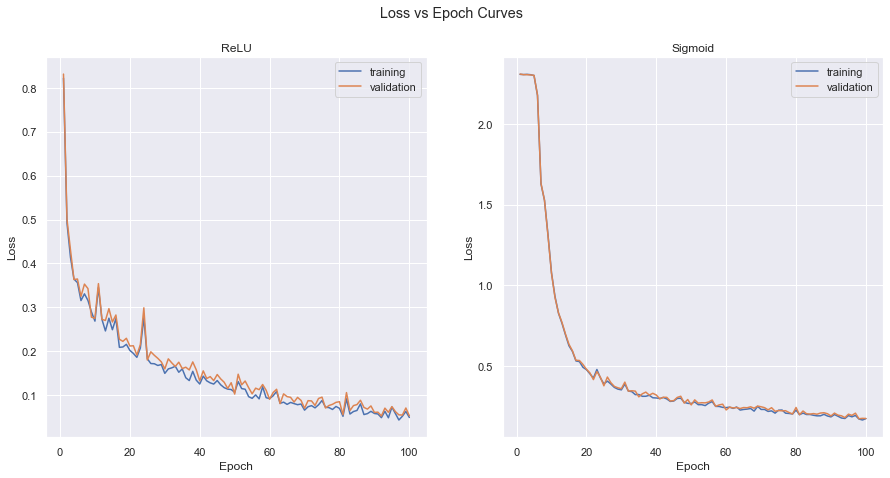

In [21]:
plot_loss_curve()

##### **Question 1: Part 6**

In [44]:
#run sklearn's MLP with ReLU as the loss function and plot losses for both.
nn1_ = MyNeuralNetwork(n_layers=3, layer_sizes=[256, 128, 64], learning_rate=0.1, num_epochs=100, batch_size=32, weight_init='normal', activation="relu")
nn1_.compare_with_mlp(training_loss["relu"], mnist_train_flat, mnist_train_labels.astype(int))

Iteration 1, loss = 0.54956344
Iteration 2, loss = 0.39268738
Iteration 3, loss = 0.35180555
Iteration 4, loss = 0.32548673
Iteration 5, loss = 0.30448772
Iteration 6, loss = 0.28825450
Iteration 7, loss = 0.27755963
Iteration 8, loss = 0.26499282
Iteration 9, loss = 0.25293950
Iteration 10, loss = 0.24534916
Iteration 11, loss = 0.23786828
Iteration 12, loss = 0.22874060
Iteration 13, loss = 0.22453215
Iteration 14, loss = 0.21619593
Iteration 15, loss = 0.20884032
Iteration 16, loss = 0.20166635
Iteration 17, loss = 0.19582943
Iteration 18, loss = 0.19350689
Iteration 19, loss = 0.18825211
Iteration 20, loss = 0.18463253
Iteration 21, loss = 0.18053355
Iteration 22, loss = 0.17362635
Iteration 23, loss = 0.16846729
Iteration 24, loss = 0.16503565
Iteration 25, loss = 0.16014472
Iteration 26, loss = 0.15701411
Iteration 27, loss = 0.15052729
Iteration 28, loss = 0.15247049
Iteration 29, loss = 0.15094679
Iteration 30, loss = 0.14705859
Iteration 31, loss = 0.14168726
Iteration 32, los

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 51, loss = 0.09510056
Iteration 52, loss = 0.09332632
Iteration 53, loss = 0.09017744
Iteration 54, loss = 0.08752531
Iteration 55, loss = 0.08784727
Iteration 56, loss = 0.08944281
Iteration 57, loss = 0.08659817
Iteration 58, loss = 0.08881744
Iteration 59, loss = 0.08484203
Iteration 60, loss = 0.08044382
Iteration 61, loss = 0.08373300
Iteration 62, loss = 0.09186337
Iteration 63, loss = 0.08279339
Iteration 64, loss = 0.07727548
Iteration 65, loss = 0.07703788
Iteration 66, loss = 0.07957713
Iteration 67, loss = 0.07602993
Iteration 68, loss = 0.07929532
Iteration 69, loss = 0.06883541
Iteration 70, loss = 0.06996957
Iteration 71, loss = 0.07174112
Iteration 72, loss = 0.07314944
Iteration 73, loss = 0.07341223
Iteration 74, loss = 0.06485513
Iteration 75, loss = 0.06167944
Iteration 76, loss = 0.07091131
Iteration 77, loss = 0.06652484
Iteration 78, loss = 0.06786373
Iteration 79, loss = 0.05557649
Iteration 80, loss = 0.05690579
Iteration 81, loss = 0.05954619
Iteratio

In [45]:
#run sklearn's MLP with tanh as the loss function and plot losses for both.
nn2_ = MyNeuralNetwork(n_layers=3, layer_sizes=[256, 128, 64], learning_rate=0.1, num_epochs=100, batch_size=32, weight_init='normal', activation="tanh")
nn2_.compare_with_mlp(training_loss["tanh"], mnist_train_flat, mnist_train_labels.astype(int))

Iteration 1, loss = 0.51471381
Iteration 2, loss = 0.39012565
Iteration 3, loss = 0.35265138
Iteration 4, loss = 0.32906033
Iteration 5, loss = 0.30909565
Iteration 6, loss = 0.29511740
Iteration 7, loss = 0.28192320
Iteration 8, loss = 0.27023572
Iteration 9, loss = 0.26000107
Iteration 10, loss = 0.25062298
Iteration 11, loss = 0.24221577
Iteration 12, loss = 0.23350708
Iteration 13, loss = 0.22560617
Iteration 14, loss = 0.21748704
Iteration 15, loss = 0.21119399
Iteration 16, loss = 0.20439609
Iteration 17, loss = 0.19863052
Iteration 18, loss = 0.19401454
Iteration 19, loss = 0.18857751
Iteration 20, loss = 0.18224309
Iteration 21, loss = 0.17595456
Iteration 22, loss = 0.17128181
Iteration 23, loss = 0.16842952
Iteration 24, loss = 0.16239848
Iteration 25, loss = 0.15823108
Iteration 26, loss = 0.15551763
Iteration 27, loss = 0.14976591
Iteration 28, loss = 0.14495453
Iteration 29, loss = 0.14051096
Iteration 30, loss = 0.13863305
Iteration 31, loss = 0.13528029
Iteration 32, los

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 51, loss = 0.08713591
Iteration 52, loss = 0.08374984
Iteration 53, loss = 0.08346095
Iteration 54, loss = 0.07820357
Iteration 55, loss = 0.07559019
Iteration 56, loss = 0.07682625
Iteration 57, loss = 0.07147350
Iteration 58, loss = 0.07782127
Iteration 59, loss = 0.06840677
Iteration 60, loss = 0.06892909
Iteration 61, loss = 0.06895629
Iteration 62, loss = 0.06917370
Iteration 63, loss = 0.07412648
Iteration 64, loss = 0.07033283
Iteration 65, loss = 0.05662873
Iteration 66, loss = 0.05580843
Iteration 67, loss = 0.05998552
Iteration 68, loss = 0.06369082
Iteration 69, loss = 0.05625851
Iteration 70, loss = 0.06043907
Iteration 71, loss = 0.06578914
Iteration 72, loss = 0.05879139
Iteration 73, loss = 0.05018764
Iteration 74, loss = 0.05452103
Iteration 75, loss = 0.05777708
Iteration 76, loss = 0.05448226
Iteration 77, loss = 0.05245753
Iteration 78, loss = 0.06224584
Iteration 79, loss = 0.05127826
Iteration 80, loss = 0.05210366
Iteration 81, loss = 0.05600223
Iteratio

In [46]:
#run sklearn's MLP with sigmoid as the loss function and plot losses for both.
nn3_ = MyNeuralNetwork(n_layers=3, layer_sizes=[256, 128, 64], learning_rate=0.1, num_epochs=100, batch_size=32, weight_init='normal', activation="sigmoid")
nn3_.compare_with_mlp(training_loss["sigmoid"], mnist_train_flat, mnist_train_labels.astype(int))

Iteration 1, loss = 2.02367717
Iteration 2, loss = 0.95720552
Iteration 3, loss = 0.74486950
Iteration 4, loss = 0.64532120
Iteration 5, loss = 0.57201175
Iteration 6, loss = 0.52005666
Iteration 7, loss = 0.48428663
Iteration 8, loss = 0.45897302
Iteration 9, loss = 0.43928874
Iteration 10, loss = 0.42327233
Iteration 11, loss = 0.40899844
Iteration 12, loss = 0.39609271
Iteration 13, loss = 0.38499294
Iteration 14, loss = 0.37518376
Iteration 15, loss = 0.36618427
Iteration 16, loss = 0.35984990
Iteration 17, loss = 0.35189751
Iteration 18, loss = 0.34644228
Iteration 19, loss = 0.34013237
Iteration 20, loss = 0.33245079
Iteration 21, loss = 0.32819861
Iteration 22, loss = 0.32184883
Iteration 23, loss = 0.31775343
Iteration 24, loss = 0.31295533
Iteration 25, loss = 0.30934649
Iteration 26, loss = 0.30446354
Iteration 27, loss = 0.29972459
Iteration 28, loss = 0.29678959
Iteration 29, loss = 0.29238674
Iteration 30, loss = 0.28929531
Iteration 31, loss = 0.28534028
Iteration 32, los

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 51, loss = 0.22609717
Iteration 52, loss = 0.22432152
Iteration 53, loss = 0.22201128
Iteration 54, loss = 0.21788792
Iteration 55, loss = 0.21718861
Iteration 56, loss = 0.21472701
Iteration 57, loss = 0.21216861
Iteration 58, loss = 0.20918891
Iteration 59, loss = 0.20893843
Iteration 60, loss = 0.20486352
Iteration 61, loss = 0.20328249
Iteration 62, loss = 0.20137630
Iteration 63, loss = 0.19995307
Iteration 64, loss = 0.19628347
Iteration 65, loss = 0.19503197
Iteration 66, loss = 0.19313242
Iteration 67, loss = 0.19057666
Iteration 68, loss = 0.18959462
Iteration 69, loss = 0.18700780
Iteration 70, loss = 0.18486090
Iteration 71, loss = 0.18423520
Iteration 72, loss = 0.18156283
Iteration 73, loss = 0.18189041
Iteration 74, loss = 0.17808105
Iteration 75, loss = 0.17534483
Iteration 76, loss = 0.17376319
Iteration 77, loss = 0.17161380
Iteration 78, loss = 0.17011892
Iteration 79, loss = 0.16819045
Iteration 80, loss = 0.16750199
Iteration 81, loss = 0.16480673
Iteratio

In [47]:
#run sklearn's MLP with linear as the loss function and plot losses for both.
nn4_ = MyNeuralNetwork(n_layers=3, layer_sizes=[256, 128, 64], learning_rate=0.1, num_epochs=100, batch_size=32, weight_init='normal', activation="linear")
nn4_.compare_with_mlp(training_loss["linear"], mnist_train_flat, mnist_train_labels.astype(int))

/usr/local/lib/python3.9/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.9/site-packages/sklearn/utils/extmath.py:153: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Iteration 1, loss = nan
Iteration 2, loss = nan
Iteration 3, loss = nan
Iteration 4, loss = nan
Iteration 5, loss = nan
Iteration 6, loss = nan
Iteration 7, loss = nan
Iteration 8, loss = nan
Iteration 9, loss = nan
Iteration 10, loss = nan
Iteration 11, loss = nan
Iteration 12, loss = nan
Iteration 13, loss = nan
Iteration 14, loss = nan
Iteration 15, loss = nan
Iteration 16, loss = nan
Iteration 17, loss = nan
Iteration 18, loss = nan
Iteration 19, loss = nan
Iteration 20, loss = nan
Iteration 21, loss = nan
Iteration 22, loss = nan
Iteration 23, loss = nan
Iteration 24, loss = nan
Iteration 25, loss = nan
Iteration 26, loss = nan
Iteration 27, loss = nan
Iteration 28, loss = nan
Iteration 29, loss = nan
Iteration 30, loss = nan
Iteration 31, loss = nan
Iteration 32, loss = nan
Iteration 33, loss = nan
Iteration 34, loss = nan
Iteration 35, loss = nan
Iteration 36, loss = nan
Iteration 37, loss = nan
Iteration 38, loss = nan
Iteration 39, loss = nan
Iteration 40, loss = nan
Iteration

/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 51, loss = nan
Iteration 52, loss = nan
Iteration 53, loss = nan
Iteration 54, loss = nan
Iteration 55, loss = nan
Iteration 56, loss = nan
Iteration 57, loss = nan
Iteration 58, loss = nan
Iteration 59, loss = nan
Iteration 60, loss = nan
Iteration 61, loss = nan
Iteration 62, loss = nan
Iteration 63, loss = nan
Iteration 64, loss = nan
Iteration 65, loss = nan
Iteration 66, loss = nan
Iteration 67, loss = nan
Iteration 68, loss = nan
Iteration 69, loss = nan
Iteration 70, loss = nan
Iteration 71, loss = nan
Iteration 72, loss = nan
Iteration 73, loss = nan
Iteration 74, loss = nan
Iteration 75, loss = nan
Iteration 76, loss = nan
Iteration 77, loss = nan
Iteration 78, loss = nan
Iteration 79, loss = nan
Iteration 80, loss = nan
Iteration 81, loss = nan
Iteration 82, loss = nan
Iteration 83, loss = nan
Iteration 84, loss = nan
Iteration 85, loss = nan
Iteration 86, loss = nan
Iteration 87, loss = nan
Iteration 88, loss = nan
Iteration 89, loss = nan
Iteration 90, loss = nan


In [10]:
validation_loss = joblib.load("validation_loss.pkl")
training_loss = joblib.load("training_loss.pkl")

Plots obtained after training Sklearn's MLP for each of the given activations are:

* ReLU activation

![ReLU-Loss-Comparison](relu_comparison.png)

* Sigmoid activation

![Sigmoid-Loss-Comparison](sigmoid_comparison.png)

* Tanh activation

![Tanh-Loss-Comparison](tanh_comparison.png)

* Linear activation

![Linear-Loss-Comparison](linear_comparison.png)

In [56]:
#load weights from the saved pickle files for sklearn and my implementation for 50 and 100 epochs and create a dataframe of accuracy on test set
accuracies = pd.DataFrame(columns=["sklearn_50_epochs", "mine_50_epochs", "sklearn_100_epochs", "mine_100_epochs"], index=["sigmoid", "tanh", "relu", "linear"])
best_accuray = 0
best_model = None
model_type = ''
best_epoch = ''
for a in ["sigmoid", "tanh", "relu", "linear"]:
    acc = []
    for epoch in ['50','100']:
        test_nn = MyNeuralNetwork(n_layers=3, layer_sizes=[256, 128, 64], learning_rate=0.1, num_epochs=5, batch_size=32, weight_init='normal', activation=a)
        weights_file = "checkpoints/"+a+"/"+epoch+"_"+a+"_weights.pkl"
        test_nn.weights = joblib.load(weights_file)
        bias_file = "checkpoints/"+a+"/"+epoch+"_"+a+"_bias.pkl"
        test_nn.bias = joblib.load(bias_file)
        sklearn_path = "checkpoints/sklearn/"+epoch+"_"+a+"_model.pkl"
        sklearn_model = joblib.load(sklearn_path)
        acc1 = sklearn_model.score(np.array(mnist_test_flat, dtype='float32'), mnist_test_labels.astype(int))*100
        acc2 = test_nn.score(np.array(mnist_test_flat, dtype='float32'), mnist_test_labels.astype(int))*100
        acc.append(acc1)
        acc.append(acc2)
        if (acc1>best_accuray):
            best_accuray = acc1
            best_model = sklearn_model
            model_type = 'sklearn'
            best_epoch = epoch
        if (acc2>best_accuray):
            best_accuray = acc2
            best_model = test_nn
            model_type = 'my'
            best_epoch = epoch
    accuracies.loc[a] = acc

In [57]:
#accuracy of all loaded models:
print("Accuracies on test set for sklearn and my implementation:")
print(tabulate(accuracies, headers='keys', tablefmt='psql'))

Accuracies on test set for sklearn and my implementation:
+---------+---------------------+------------------+----------------------+-------------------+
|         |   sklearn_50_epochs |   mine_50_epochs |   sklearn_100_epochs |   mine_100_epochs |
|---------+---------------------+------------------+----------------------+-------------------|
| sigmoid |             88.3167 |          88.4667 |              87.9833 |             88.8  |
| tanh    |             88.05   |          89.2833 |              87.5667 |             88.45 |
| relu    |             88.7333 |          89.7    |              88.7167 |             89.45 |
| linear  |              9.95   |           9.95   |               9.95   |              9.95 |
+---------+---------------------+------------------+----------------------+-------------------+


In [59]:
#best overall model in terms of accuracy
print("Best model in terms of accuracy is "+model_type+ " MLP with "+best_model.activation+" as the loss function after "+ best_epoch+" epochs")
print("Best accuracy obtained: "+str(best_accuray)+"%")

Best model in terms of accuracy is my MLP with relu as the loss function after 50 epochs
Best accuracy obtained: 89.7%
